# ENVIROMENT

## Setting the environment

In [1]:
!rm -rf ./ta-lib*

In [2]:
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz
%cd ta-lib
!./configure --prefix=/usr
!make
!make install
!pip install Ta-Lib
!pip install yfinance==0.2.20
!pip install plot-keras-history

%cd ..

 gcc -DHAVE_CONFIG_H -I. -I../../include -DTA_GEN_CODE -I../ta_common/ -Iframes/ -g -O2 -MT libta_abstract_gc_la-table_x.lo -MD -MP -MF .deps/libta_abstract_gc_la-table_x.Tpo -c tables/table_x.c  -fPIC -DPIC -o .libs/libta_abstract_gc_la-table_x.o
 gcc -DHAVE_CONFIG_H -I. -I../../include -DTA_GEN_CODE -I../ta_common/ -Iframes/ -g -O2 -MT libta_abstract_gc_la-table_x.lo -MD -MP -MF .deps/libta_abstract_gc_la-table_x.Tpo -c tables/table_x.c -o libta_abstract_gc_la-table_x.o >/dev/null 2>&1
mv -f .deps/libta_abstract_gc_la-table_x.Tpo .deps/libta_abstract_gc_la-table_x.Plo
/bin/bash ../../libtool --tag=CC   --mode=compile gcc -DHAVE_CONFIG_H -I. -I../../include  -DTA_GEN_CODE -I../ta_common/ -Iframes/   -g -O2 -MT libta_abstract_gc_la-table_y.lo -MD -MP -MF .deps/libta_abstract_gc_la-table_y.Tpo -c -o libta_abstract_gc_la-table_y.lo `test -f 'tables/table_y.c' || echo './'`tables/table_y.c
 gcc -DHAVE_CONFIG_H -I. -I../../include -DTA_GEN_CODE -I../ta_common/ -Iframes/ -g -O2 -MT libta_ab

## Imports

In [3]:
# General
import pandas as pd
import yfinance as yf
import numpy as np
import talib
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import pickle

#Sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from plot_keras_history import show_history, plot_history
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_absolute_error

# TensorFlow & Keras
import tensorflow as tf
tf.random.set_seed(42)

from tensorflow import keras
from tensorflow.keras import layers

import keras.optimizers

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling1D, Flatten, Dense, MaxPooling2D, MaxPooling3D,Conv3D, Conv1D

from tensorflow.keras.layers import LSTM, Dense

import warnings
warnings.filterwarnings("ignore")

2023-08-17 14:19:45.189068: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-17 14:19:45.323476: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-08-17 14:19:45.323510: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-08-17 14:19:45.354430: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-08-17 14:19:49.436416: W tensorflow/stream_executor/platform/de

# TICKERS TO ANALIZE

In [4]:
symbols = ["GOOG"]

# FUNCTIONS

## Modelling dataframe

### Inputs

In [5]:
start_date="2000-01-01"
end_date="2023-07-10"
per=0.03 #Percentage over and lower of the initial price to decide if took action or not
size=1000

In [6]:
ratio_bancos = {}

def df_generator(symbols,per=0.03,start_date="2000-01-01",end_date="2023-07-10",norm=False):
    
    data_dict={}
    X_train={}
    y_train={}
    X_test={}
    y_test={}
    X_val={}
    y_val={}
    
    for symbol in symbols:

        #1 Fetch data
        data = yf.download(tickers=symbol, start=start_date,end=end_date)

        ### Esto lo podemos limpia y dejarlo dentro del loop, sin salir a la variable ratio_bancos
        ### Lo vemos ahora
        ratio_bancos[symbol] = data['Close'][0]/data['Adj Close'][0]
        data.insert(1, 'Adj_open', data['Open'] / ratio_bancos[symbol])
        data.insert(3, 'Adj_high', data['High'] / ratio_bancos[symbol])
        data.insert(5, 'Adj_low', data['Low'] / ratio_bancos[symbol])

        data.rename(columns={'Adj Close':'Adj_close'},inplace=True)

        #2 Calc percentages
        data = data[~(data == 0).any(axis=1)]
        data['Percentage'] = ((data['Adj_close'] - data['Adj_open']) / (data['Adj_open'])) * 100
        data['Log_daily_return'] = np.nan
        data['Log_daily_return'][:-1] = np.diff(np.log10(data['Adj_close']/data['Adj_open']))
        
        data['Percentage-ND'] = data['Percentage'].shift(-1)

        #3 Calculating Technical Indicators
        data['sma'] = talib.SMA(data['Adj_close'], timeperiod=20)
        data['ema'] = talib.EMA(data['Adj_close'], timeperiod=20)
        macd, signal, _ = talib.MACD(data['Adj_close'])
        data['macd'] = macd
        data['rsi'] = talib.RSI(data['Adj_close'], timeperiod=14)
        slowk, slowd = talib.STOCH(data['Adj_high'], data['Adj_low'], data['Adj_close'])
        data['stoch'] = slowk
        # data['stoch_eli'] = ((data['Adj_close]-data['Adj_low'].rolling(window=14).min())/(data['Adj_high'].rolling(window=14).max()-data['Adj_low'].rolling(window=14).min()))*100
        data['atr'] = talib.ATR(data['Adj_high'], data['Adj_low'], data['Adj_close'])
        upperband, middleband, lowerband = talib.BBANDS(data['Adj_close'])
        data['bb_high'] = upperband
        data['bb_low'] = lowerband

        # Calculate VWAP manually
        data['vwap'] = (data['Adj_close'] * data['Volume']).cumsum() / data['Volume'].cumsum()

        data['obv'] = talib.OBV(data['Adj_close'], data['Volume'])

        # Calculate OBV manually
        data['obv'] = ((data['Adj_close'] - data['Adj_close'].shift(1)).fillna(0) * data['Volume']).cumsum()

        # Calculate CMF manually
        money_flow_multiplier = ((data['Adj_close'] - data['Adj_low']) - (data['Adj_high'] - data['Adj_close'])) / (data['Adj_high'] - data['Adj_low'])
        money_flow_volume = money_flow_multiplier * data['Volume']
        data['cmf'] = money_flow_volume.rolling(window=20).sum() / data['Volume'].rolling(window=20).sum()

        data['cci'] = talib.CCI(data['Adj_high'], data['Adj_low'], data['Adj_close'])
        data['roc'] = talib.ROC(data['Adj_close'],timeperiod=10)


        # FLAGS
        # data[ema_flag] = np.where(data['Adj_close'] > data['ema'], -1, data['Adj_close'] < data['ema'],1,0)
        # data[stock_eli_flag] = np.where(data['Adj_close'] > data['stoch_eli'], -1, data['Adj_close'] < data['stoch_eli'],1,0)
        data['sma_ema_flag'] = np.where(data['sma'] > data['ema'], 1, np.where(data['sma'] == data['ema'], 0, -1))
        data['macd_flag'] = np.where(data['macd'] > 0, 1, np.where(data['macd'] == 0, 0, -1))
        data['stoch_flag'] = np.where(data['stoch'] > 50, 1, np.where(data['stoch'] < 50, -1, 0))
        data['vwap_flag'] = np.where(data['vwap'] > data['Adj_close'] * 1.01, 1, np.where(data['vwap'] < data['Adj_close'] * 0.99, -1, 0))
        data['obv_flag'] = np.where(data['obv'] > 0, 1, np.where(data['obv'] < 0, -1, 0))
        data['cmf_flag'] = np.where(data['cmf'] > 0, 1, np.where(data['cmf'] < 0, -1, 0))
        data['cci_flag'] = np.where((data['cci'] > -100) & (data['cci'] < 100), 1, 0)
        data['roc_flag'] = np.where(data['roc'] > 0, 1, np.where(data['roc'] < 0, -1, 0))


        #4 Candlestick Patterns
        # 0 no se identifica patron, 100 se identifica patron alcista, -100 se identifica patron bajista
        data['CDL2CROWS'] = talib.CDL2CROWS(data['Adj_open'], data['Adj_high'], data['Adj_low'], data['Adj_close'])

        # 0 no se identifica patron, 100 se identifica patron alcista, -100 se identifica patron bajista
        data['CDL3BLACKCROWS'] = talib.CDL3BLACKCROWS(data['Adj_open'], data['Adj_high'], data['Adj_low'], data['Adj_close'])

        # 0 no se identifica patron, 100 se identifica patron alcista, -100 se identifica patron bajista
        data['CDL3INSIDE'] = talib.CDL3INSIDE(data['Adj_open'], data['Adj_high'], data['Adj_low'], data['Adj_close'])

        # 0 no se identifica patron, 100 se identifica patron alcista, -100 se identifica patron bajista
        data['CDL3LINESTRIKE'] = talib.CDL3LINESTRIKE(data['Adj_open'], data['Adj_high'], data['Adj_low'], data['Adj_close'])

        # 0 no se identifica patron, 100 se identifica patron alcista, -100 se identifica patron bajista
        data['CDL3OUTSIDE'] = talib.CDL3OUTSIDE(data['Adj_open'], data['Adj_high'], data['Adj_low'], data['Adj_close'])

        # 0 no se identifica patron, 100 se identifica patron alcista
        data['CDL3STARSINSOUTH'] = talib.CDL3STARSINSOUTH(data['Adj_open'], data['Adj_high'], data['Adj_low'], data['Adj_close'])

        # 0 no se identifica patron, 100 se identifica patron alcista
        data['CDL3WHITESOLDIERS'] = talib.CDL3WHITESOLDIERS(data['Adj_open'], data['Adj_high'], data['Adj_low'], data['Adj_close'])
        
        # 0 no se identifica patron, 100 se identifica patron alcista, -100 se identifica patron bajista
        data['CDLABANDONEDBABY'] = talib.CDLABANDONEDBABY(data['Adj_open'], data['Adj_high'], data['Adj_low'], data['Adj_close'])

        # 0 no se identifica patron, 100 se identifica patron alcista
        data['CDLADVANCEBLOCK'] = talib.CDLADVANCEBLOCK(data['Adj_open'], data['Adj_high'], data['Adj_low'], data['Adj_close'])

        # 0 no se identifica patron, 100 se identifica patron alcista, -100 se identifica patron bajista
        data['CDLBELTHOLD'] = talib.CDLBELTHOLD(data['Adj_open'], data['Adj_high'], data['Adj_low'], data['Adj_close'])

        # 0 no se identifica patron, 1 a 5 se identifica patron alcista (mas alto, mas fuerza), -1 a -5 se identifica patron bajista (mas bajo, mas fuerza bajista)
        data['CDLBREAKAWAY'] = talib.CDLBREAKAWAY(data['Adj_open'], data['Adj_high'], data['Adj_low'], data['Adj_close'])

        # 0 no se identifica patron, 100 se identifica patron alcista, -100 se identifica patron bajista
        data['CDLCLOSINGMARUBOZU'] = talib.CDLCLOSINGMARUBOZU(data['Adj_open'], data['Adj_high'], data['Adj_low'], data['Adj_close'])

        # 0 no se identifica patron, 100 se identifica patron alcista
        data['CDLCONCEALBABYSWALL'] = talib.CDLCONCEALBABYSWALL(data['Adj_open'], data['Adj_high'], data['Adj_low'], data['Adj_close'])

        # 0 no se identifica patron, 100 se identifica patron alcista, -100 se identifica patron bajista
        data['CDLCOUNTERATTACK'] = talib.CDLCOUNTERATTACK(data['Adj_open'], data['Adj_high'], data['Adj_low'], data['Adj_close'])

        # 0 no se identifica patron, 100 se identifica patron bajista
        data['CDLDARKCLOUDCOVER'] = talib.CDLDARKCLOUDCOVER(data['Adj_open'], data['Adj_high'], data['Adj_low'], data['Adj_close'])

        # 0 no se identifica patron, 100 se identifica patron alcista, -100 se identifica patron bajista
        data['CDLDOJI'] = talib.CDLDOJI(data['Adj_open'], data['Adj_high'], data['Adj_low'], data['Adj_close'])

        # 0 no se identifica patron, 100 se identifica patron alcista, -100 se identifica patron bajista
        data['CDLDOJISTAR'] = talib.CDLDOJISTAR(data['Adj_open'], data['Adj_high'], data['Adj_low'], data['Adj_close'])

        # 0 no se identifica patron, 100 se identifica patron alcista
        data['CDLDRAGONFLYDOJI'] = talib.CDLDRAGONFLYDOJI(data['Adj_open'], data['Adj_high'], data['Adj_low'], data['Adj_close'])

        # 0 no se identifica patron, 100 se identifica patron alcista, -100 se identifica patron bajista
        data['CDLENGULFING'] = talib.CDLENGULFING(data['Adj_open'], data['Adj_high'], data['Adj_low'], data['Adj_close'])

        # 0 no se identifica patron, 100 se identifica patron bajista
        data['CDLEVENINGDOJISTAR'] = talib.CDLEVENINGDOJISTAR(data['Adj_open'], data['Adj_high'], data['Adj_low'], data['Adj_close'])

        # 0 no se identifica patron, 100 se identifica patron bajista
        data['CDLEVENINGSTAR'] = talib.CDLEVENINGSTAR(data['Adj_open'], data['Adj_high'], data['Adj_low'], data['Adj_close'])

        # 0 no se identifica patron, 100 se identifica patron alcista
        data['CDLGAPSIDESIDEWHITE'] = talib.CDLGAPSIDESIDEWHITE(data['Adj_open'], data['Adj_high'], data['Adj_low'], data['Adj_close'])

        #5 Generating the Y

        data['Target'] = np.where(per <= data['Percentage-ND'], 1,np.where(-per >= data['Percentage-ND'], -1, 0))
        data['Target_1'] = data['Target'].shift()
        data['Target_2'] = data['Target_1'].shift()
        data['Target_3'] = data['Target_2'].shift()
        data['Target_4'] = data['Target_3'].shift()
        data['Target_5'] = data['Target_4'].shift()
        
       #1=Buy, 0=Nothing -1=Sell
 

        # if norm:
        #     cols_to_normalize = [col for col in data.columns if col not in ['Target', 'Percentage', 'Percentage-ND']]
        #     data[cols_to_normalize] = (data[cols_to_normalize] - data[cols_to_normalize].mean()) / data[cols_to_normalize].std()
        
        if norm:
            cols_to_normalize = [col for col in data.columns if col not in ['Target', 'Percentage', 'Percentage-ND']]
            scaler = MinMaxScaler()
            data[cols_to_normalize] = scaler.fit_transform(data[cols_to_normalize])

        
        columns_to_drop = [col for col in data.columns if col != 'Percentage-ND']
        data = data.dropna(subset=columns_to_drop)


        data_dict[symbol] = data

        
        data=data.drop(columns=['Percentage-ND'])
        X_train[symbol] = data[:int(len(data)*.5)].dropna()
        y_train[symbol] = X_train[symbol].pop('Target')
        X_val[symbol] = data[int(len(data)*.5):int(len(data)*.2)+int(len(data)*.5)]
        y_val[symbol] = X_val[symbol].pop('Target')
        X_test[symbol] = data[int(len(data)*.2)+int(len(data)*.5):]
        y_test[symbol] = X_test[symbol].pop('Target')

    start_date_obj = datetime.strptime(start_date, "%Y-%m-%d")
    end_date_obj = datetime.strptime(end_date, "%Y-%m-%d")
    difference = end_date_obj - start_date_obj
    days_difference = difference.days

    print(f'Tickers:{symbols}')
    print(f"We are going to work with a period of {days_difference} days.")

    
    return data_dict, X_train, y_train, X_val, y_val, X_test, y_test


## Deleting unwanted class  

In [7]:
def taking_target(data_dict, X_train, y_train, X_val, y_val, X_test, y_test, target, symbols=symbols):
   
    for symbol in symbols:
        data = data_dict[symbol].loc[data_dict[symbol]['Target'] != target].copy()

        data_dict[symbol] = data
        
        data=data.drop(columns=['Percentage-ND'])
        X_train[symbol] = data[:int(len(data)*.5)].dropna()
        y_train[symbol] = X_train[symbol].pop('Target')
        X_val[symbol] = data[int(len(data)*.5):int(len(data)*.2)+int(len(data)*.5)]
        y_val[symbol] = X_val[symbol].pop('Target')
        X_test[symbol] = data[int(len(data)*.2)+int(len(data)*.5):]
        y_test[symbol] = X_test[symbol].pop('Target')

    return data_dict, X_train, y_train, X_val, y_val, X_test, y_test

## Backtesting

In [8]:
def backtest(data_dict, capital=100000,reverse=False,size=1000):
    portfolio = {'capital': capital, 'shares': 0, 'value': capital}
    trades = []

    ### If the accuracy is less than 20% for the model, we can reverse the way it buys an sells ###
    ### If the Target signal is showing 1 Buy, it will sell and viceversa      ###

    if reverse==True:
        reverse= -1
    else:
        reverse = 1

    for symbol, data in data_dict.items():

        for index, row in data.iterrows():


            signal = row['Target']*reverse
            
            if signal == 1:  # Buy signal

                shares_to_buy_total = int(portfolio['capital'] / row['Open'])
                shares_to_buy = int(size / row['Open'])
                cost = shares_to_buy * row['Open']
                portfolio['shares'] += shares_to_buy
                portfolio['capital'] -= cost
                
                shares_to_sell = shares_to_buy
                proceeds = shares_to_sell * row['Close']
                portfolio['shares'] -= shares_to_sell
                portfolio['capital'] += proceeds

                
                percent = (row['Close'] - row['Open']) / row['Open'] * 100
                portfolio['value'] = portfolio['capital'] + (portfolio['shares'] * row['Close'])
                
                trades.append({'date': index, 
                               'open_price': row['Open'], 
                               'close_price': row['Close'], 
                               'percentage': percent, 
                               'action': 'Buy', 
                               'shares': shares_to_buy, 
                               'symbol': symbol, 
                               'capital': portfolio['value'],
                               'shares_total':shares_to_buy_total})


            elif signal == -1:  # Sell signal

                shares_to_sell_total = int(portfolio['capital'] / row['Open'])
                shares_to_sell = int(size / row['Open'])
                proceeds = shares_to_sell * row['Open']
                portfolio['shares'] -= shares_to_sell
                portfolio['capital'] += proceeds
                                
                shares_to_buy = shares_to_sell
                cost = shares_to_buy * row['Close']
                portfolio['shares'] += shares_to_buy
                portfolio['capital'] -= cost
                
                percent = (row['Close'] - row['Open']) / row['Open'] * 100
                portfolio['value'] = portfolio['capital'] + (portfolio['shares'] * row['Close'])

                trades.append({'date': index,
                               'open_price': row['Open'],
                               'close_price': row['Close'],
                               'percentage': percent,
                               'action': 'Sell',
                               'shares': shares_to_buy,
                               'symbol': symbol,
                               'capital': portfolio['value'],
                               'shares_total':shares_to_sell_total})

    return trades, portfolio

## Plotting function (Buy & Hold vs model)

In [9]:
def plotter(symbols,test_df,size=size):
    data_dict = {symbols[-1]: test_df}
    
    trades, portfolio = backtest(data_dict,reverse=False)
    trades=pd.DataFrame(trades)
    trades=trades.set_index('date')[['shares','capital','close_price','shares_total','open_price']]
    
    plt.plot(trades.index,trades['capital']/trades['shares_total']*trades['shares'].iloc[0]+99000, label='BUY&HOLD')
    # print(trades.index,trades['capital']/trades['shares_total'],trades['shares_total'].iloc[0])
    plt.plot(trades.index,trades['capital'], label='MODEL')
    # plt.plot(pd.DataFrame(trades).index,pd.DataFrame(trades)['close_price']*pd.DataFrame(trades)['shares'][0])
    plt.legend()
    plt.xlabel('Date')
    plt.ylabel('Capital')
    plt.title('Capital Over Time')
    plt.show()




#  EXPLORATORY DATA ANALYSIS

## Dataset Generation for EDA

In [10]:
symbols = ["GOOG"]
data_dict, X_train, y_train, X_val, y_val, X_test, y_test = \
df_generator(symbols,per=per,end_date=end_date,start_date=start_date)
print('\n\nDATA NORMALIZED\n\n')
data_dict_norm, X_train_norm, y_train_norm, X_val_norm, y_val_norm, X_test_norm, y_test_norm = \
df_generator(symbols,per=per,end_date=end_date,start_date=start_date,norm=True)

[*********************100%***********************]  1 of 1 completed
Tickers:['GOOG']
We are going to work with a period of 8591 days.


DATA NORMALIZED


[*********************100%***********************]  1 of 1 completed
Tickers:['GOOG']
We are going to work with a period of 8591 days.


In [11]:
data_dict['GOOG']

,Open,Adj_open,High,Adj_high,Low,Adj_low,Close,Adj_close,Volume,Percentage,...,CDLENGULFING,CDLEVENINGDOJISTAR,CDLEVENINGSTAR,CDLGAPSIDESIDEWHITE,Target,Target_1,Target_2,Target_3,Target_4,Target_5
Date,,,,,,,,,,,,,,,,,,,,,
2004-10-06,3.425909,3.425909,3.448325,3.448325,3.387304,3.387304,3.414203,3.414203,268900140,-0.341694,...,0,0,0,0,1,-1.0,1.0,-1.0,1.0,-1.0
2004-10-07,3.410218,3.410218,3.483941,3.483941,3.401002,3.401002,3.458287,3.458287,283643194,1.409558,...,100,0,0,0,-1,1.0,-1.0,1.0,-1.0,1.0
2004-10-08,3.455050,3.455050,3.478960,3.478960,3.412708,3.412708,3.430392,3.430392,222442656,-0.713679,...,0,0,0,0,-1,-1.0,1.0,-1.0,1.0,-1.0
2004-10-11,3.412210,3.412210,3.458537,3.458537,3.333754,3.333754,3.368873,3.368873,210437827,-1.270060,...,0,0,0,0,1,-1.0,-1.0,1.0,-1.0,1.0
2004-10-12,3.348449,3.348449,3.427403,3.427403,3.322546,3.322546,3.422173,3.422173,234419380,2.201737,...,100,0,0,0,-1,1.0,-1.0,-1.0,1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-29,120.089996,120.089996,120.910004,120.910004,119.209999,119.209999,120.010002,120.010002,18517500,-0.066612,...,0,0,0,0,-1,-1.0,1.0,1.0,-1.0,1.0
2023-06-30,121.099998,121.099998,122.029999,122.029999,120.879997,120.879997,120.970001,120.970001,23865800,-0.107347,...,0,0,0,0,1,-1.0,-1.0,1.0,1.0,-1.0
2023-07-03,120.320000,120.320000,121.019997,121.019997,119.705002,119.705002,120.559998,120.559998,13888300,0.199466,...,0,0,0,0,1,1.0,-1.0,-1.0,1.0,1.0


## EDA

In [12]:
for bank in data_dict:
    print(data_dict[bank].isnull().sum())

Open        0
Adj_open    0
High        0
Adj_high    0
Low         0
           ..
Target_1    0
Target_2    0
Target_3    0
Target_4    0
Target_5    0
Length: 61, dtype: int64


In [13]:
data_dict['GOOG'][:].reset_index()

,Date,Open,Adj_open,High,Adj_high,Low,Adj_low,Close,Adj_close,Volume,...,CDLENGULFING,CDLEVENINGDOJISTAR,CDLEVENINGSTAR,CDLGAPSIDESIDEWHITE,Target,Target_1,Target_2,Target_3,Target_4,Target_5
0,2004-10-06,3.425909,3.425909,3.448325,3.448325,3.387304,3.387304,3.414203,3.414203,268900140,...,0,0,0,0,1,-1.0,1.0,-1.0,1.0,-1.0
1,2004-10-07,3.410218,3.410218,3.483941,3.483941,3.401002,3.401002,3.458287,3.458287,283643194,...,100,0,0,0,-1,1.0,-1.0,1.0,-1.0,1.0
2,2004-10-08,3.455050,3.455050,3.478960,3.478960,3.412708,3.412708,3.430392,3.430392,222442656,...,0,0,0,0,-1,-1.0,1.0,-1.0,1.0,-1.0
3,2004-10-11,3.412210,3.412210,3.458537,3.458537,3.333754,3.333754,3.368873,3.368873,210437827,...,0,0,0,0,1,-1.0,-1.0,1.0,-1.0,1.0
4,2004-10-12,3.348449,3.348449,3.427403,3.427403,3.322546,3.322546,3.422173,3.422173,234419380,...,100,0,0,0,-1,1.0,-1.0,-1.0,1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4714,2023-06-29,120.089996,120.089996,120.910004,120.910004,119.209999,119.209999,120.010002,120.010002,18517500,...,0,0,0,0,-1,-1.0,1.0,1.0,-1.0,1.0
4715,2023-06-30,121.099998,121.099998,122.029999,122.029999,120.879997,120.879997,120.970001,120.970001,23865800,...,0,0,0,0,1,-1.0,-1.0,1.0,1.0,-1.0
4716,2023-07-03,120.320000,120.320000,121.019997,121.019997,119.705002,119.705002,120.559998,120.559998,13888300,...,0,0,0,0,1,1.0,-1.0,-1.0,1.0,1.0
4717,2023-07-05,120.059998,120.059998,123.370003,123.370003,120.059998,120.059998,122.629997,122.629997,17830300,...,0,0,0,0,1,1.0,1.0,-1.0,-1.0,1.0


In [14]:
columns_to_print = ['Adj_open','Adj_high','Adj_low','Adj_close']

Repartir los indicadores entre los 4

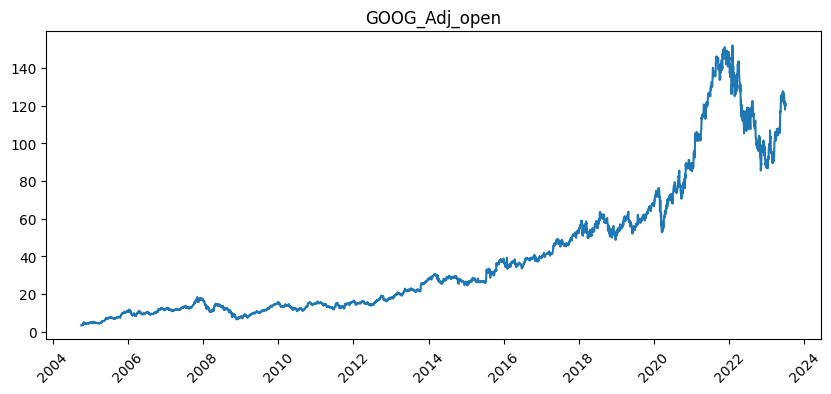

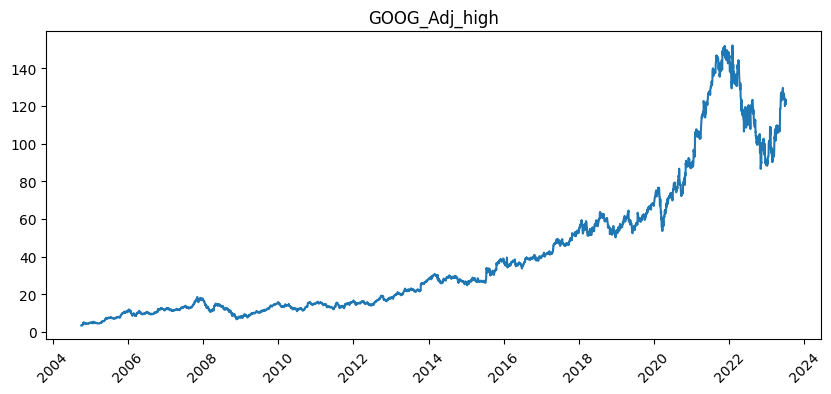

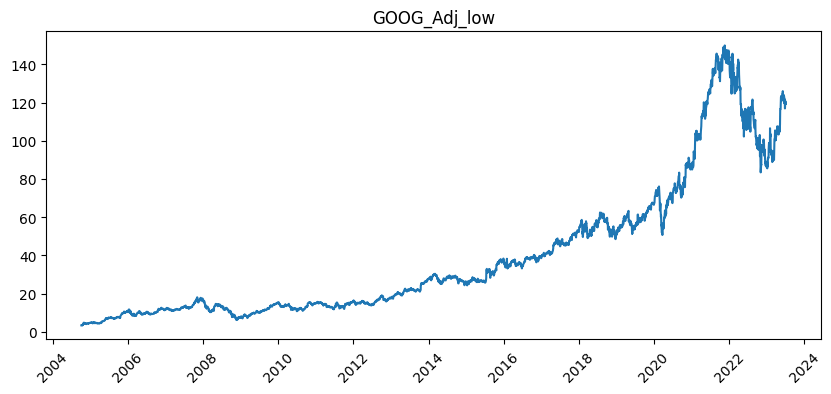

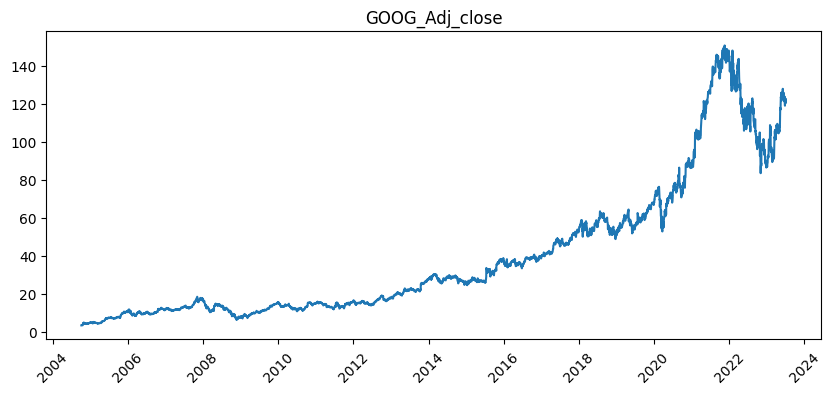

In [15]:
for bank in data_dict.keys():
    for col in data_dict[bank][columns_to_print]:
        plt.figure(figsize=(10, 4))
        plt.plot(data_dict[bank].index, data_dict[bank][col])
        plt.xticks(rotation=45)
        plt.title(bank + "_" + col)
        plt.show()

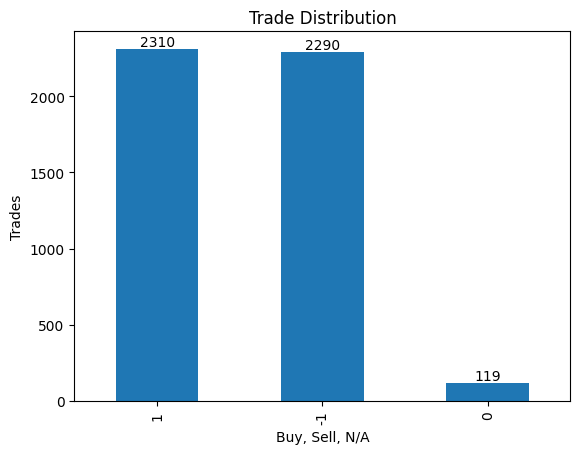

In [16]:
value_counts = data_dict['GOOG'].Target.value_counts()

ax = value_counts.plot(kind='bar')

plt.xlabel('Buy, Sell, N/A')
plt.ylabel('Trades')
plt.title('Trade Distribution')

for i, value in enumerate(value_counts):
    ax.annotate(str(value), xy=(i, value), ha='center', va='bottom')

plt.show()


With this distribution we can see that the third class, in this case "0" or "Do not take action" it's unnecesary to take in cosideration due to its size.

In [17]:
taking_target(data_dict, X_train, y_train, X_val, y_val, X_test,y_test,target=0)

({'GOOG':                   Open    Adj_open        High    Adj_high         Low  \
  Date                                                                     
  2004-10-06    3.425909    3.425909    3.448325    3.448325    3.387304   
  2004-10-07    3.410218    3.410218    3.483941    3.483941    3.401002   
  2004-10-08    3.455050    3.455050    3.478960    3.478960    3.412708   
  2004-10-11    3.412210    3.412210    3.458537    3.458537    3.333754   
  2004-10-12    3.348449    3.348449    3.427403    3.427403    3.322546   
  ...                ...         ...         ...         ...         ...   
  2023-06-29  120.089996  120.089996  120.910004  120.910004  119.209999   
  2023-06-30  121.099998  121.099998  122.029999  122.029999  120.879997   
  2023-07-03  120.320000  120.320000  121.019997  121.019997  119.705002   
  2023-07-05  120.059998  120.059998  123.370003  123.370003  120.059998   
  2023-07-06  120.639999  120.639999  121.150002  121.150002  119.250000   
  
 

## Sharpe Ratio

[*********************100%***********************]  1 of 1 completed
Sharpe Ratio for year:
2004 0.013478587909709561
2005 -0.02050225420845872
2006 -0.1203898558868895
2007 -0.05043605075459582
2008 -0.09903062099291352
2009 0.08539913971324674
2010 -0.12481863916965805
2011 -0.03890903924864332
2012 -0.010313067616725513
2013 0.06534400682594146
2014 -0.12629978644000509
2015 -0.027924126242930124
2016 -0.053435014402180174
2017 0.06860013104039546
2018 -0.03146493044815816
2019 0.09666298065634935
2020 0.09376621945126118
2021 0.10160991747252703
2022 -0.04410703978584477
2023 0.23359333342350366


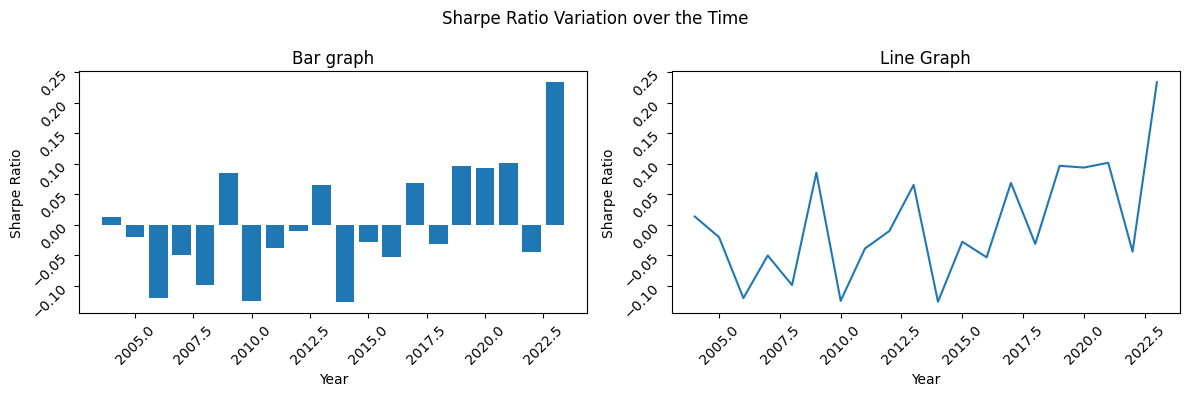

In [18]:
bonds = ["^TNX"]  # Ticker for the Treasure Yield in Yahoo Finance

grouped_bond_year = {}
grouped_year = {}
bond_by_year = {}
stock_by_year = {}
average_return = {}
risk_free = {}
std_deviation = {}
sharpe_ratio = {}

for bond in bonds:
    bond_data = yf.download(tickers=bond, start=start_date, end=end_date)
    grouped_bond_year[bond] = bond_data.groupby(pd.Grouper(freq='Y'))

for symbol in symbols:
    grouped_year[symbol] = data_dict[symbol].groupby(pd.Grouper(freq='Y'))

for bond in bonds:
    for year, group in grouped_bond_year[bond]:
        bond_by_year[year.year] = group
        risk_free[year.year] = bond_by_year[year.year]['Adj Close'].mean() / 100

for symbol in symbols:
    for year, group in grouped_year[symbol]:
        stock_by_year[year.year] = group
        average_return[year.year] = stock_by_year[year.year]['Percentage'].mean()
        std_deviation[year.year] = stock_by_year[year.year]['Percentage'].std()

# Calculate Sharpe Ratio for year:
for year in stock_by_year.keys():
    sharpe_ratio[year] = (average_return[year] - risk_free[year]) / std_deviation[year]

print("Sharpe Ratio for year:")
for year, ratio in sharpe_ratio.items():
    print(year, ratio)

years = list(sharpe_ratio.keys())
ratios = list(sharpe_ratio.values())

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle('Sharpe Ratio Variation over the Time')

axs[0].bar(years, ratios)
axs[0].set_xlabel('Year')
axs[0].set_ylabel('Sharpe Ratio')
axs[0].set_title( 'Bar graph')
axs[0].tick_params(rotation=45)

axs[1].plot(years, ratios)
axs[1].set_xlabel('Year')
axs[1].set_ylabel('Sharpe Ratio')
axs[1].set_title('Line Graph')
axs[1].tick_params(rotation=45)

plt.tight_layout() 
plt.show()



# DATASET GENERATION

In [19]:
symbols = ["GOOG"]
data_dict, X_train, y_train, X_val, y_val, X_test, y_test = \
df_generator(symbols,per=per,end_date=end_date,start_date=start_date)
print('\n\nDATA NORMALIZED\n\n')
data_dict_norm, X_train_norm, y_train_norm, X_val_norm, y_val_norm, X_test_norm, y_test_norm = \
df_generator(symbols,per=per,end_date=end_date,start_date=start_date,norm=True)

[*********************100%***********************]  1 of 1 completed
Tickers:['GOOG']
We are going to work with a period of 8591 days.


DATA NORMALIZED


[*********************100%***********************]  1 of 1 completed
Tickers:['GOOG']
We are going to work with a period of 8591 days.


In [20]:
data_dict_norm, X_train_norm, y_train_norm, X_val_norm, y_val_norm, \
X_test_norm, y_test_norm = taking_target(data_dict_norm,
                                           X_train_norm,
                                           y_train_norm,
                                           X_val_norm,
                                           y_val_norm,
                                           X_test_norm,
                                           y_test_norm,
                                           target=0)
                                           
data_dict, X_train, y_train, X_val, y_val,\
X_test, y_test = taking_target(data_dict,
                                X_train,
                                y_train,
                                X_val,
                                y_val,
                                X_test,
                                y_test,
                                target=0)

# MODELS

## Recurrent Neural Networks

In [21]:
X_train_reshaped = np.reshape(X_train_norm['GOOG'].values, (X_train_norm['GOOG'].shape[0], X_train_norm['GOOG'].shape[1], 1))

model_rnr = Sequential()
model_rnr.add(LSTM(20, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2]))) 
model_rnr.add(Dense(100, activation='relu'))
model_rnr.add(Dense(1, activation='sigmoid')) 

model_rnr.compile(loss='mae', optimizer='adam', metrics=['accuracy', 'mae', 'mse'])

history_rnr = model_rnr.fit(X_train_reshaped, y_train_norm['GOOG'], epochs=10, validation_data=(X_val_norm['GOOG'], y_val_norm['GOOG']))

X_test_reshaped = np.reshape(X_test_norm['GOOG'].values, (X_test_norm['GOOG'].shape[0], X_test_norm['GOOG'].shape[1], 1))

loss, accuracy, mae, mse = model_rnr.evaluate(X_test_reshaped, y_test_norm['GOOG'])
print("Loss:", loss)
print("Accuracy:", accuracy)
print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)

2023-08-17 14:20:03.162131: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-08-17 14:20:03.162172: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-08-17 14:20:03.162194: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (p-dda2d425-17f7-4b78-8eda-6ab769d91924): /proc/driver/nvidia/version does not exist
2023-08-17 14:20:03.162481: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
Epoch 1/10
72/72 [==============================] - 4s 34ms/step - loss: 1.0160 - ac

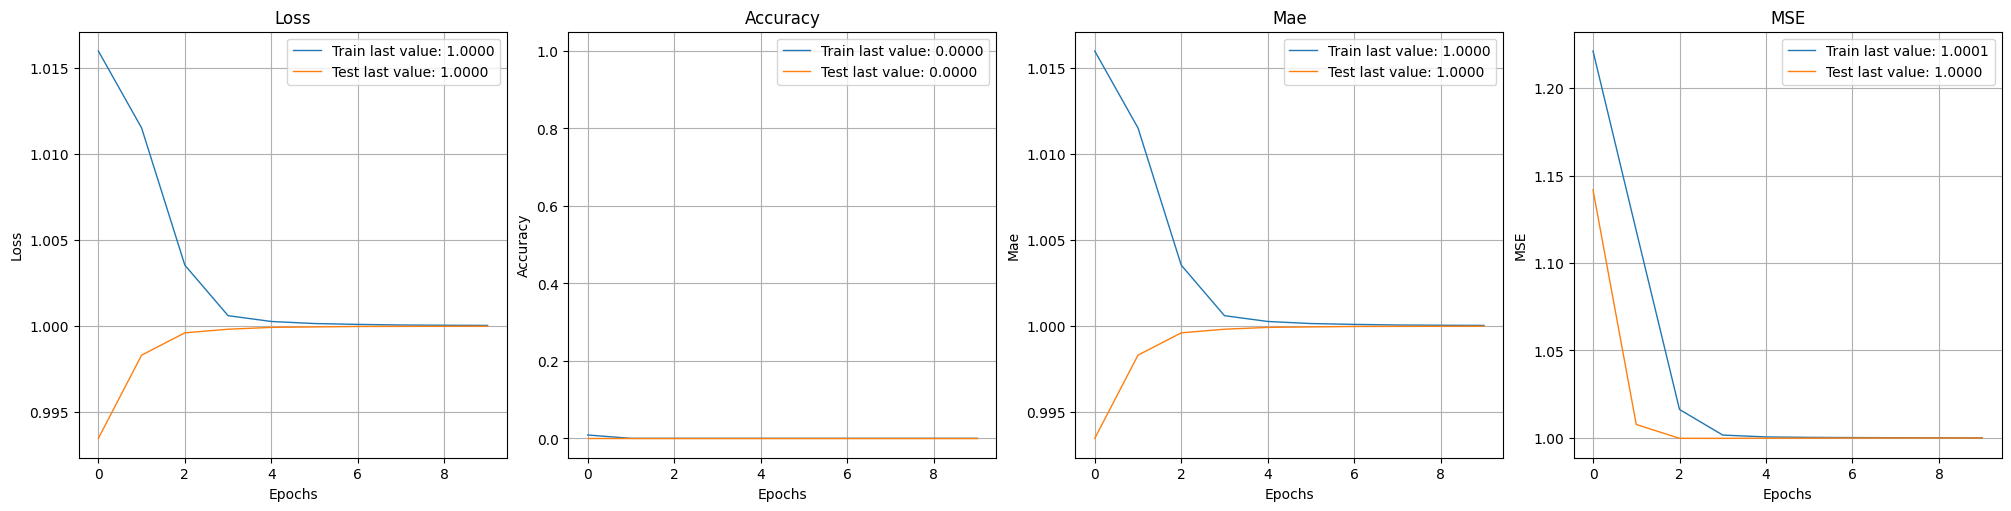

<Figure size 1000x1000 with 0 Axes>

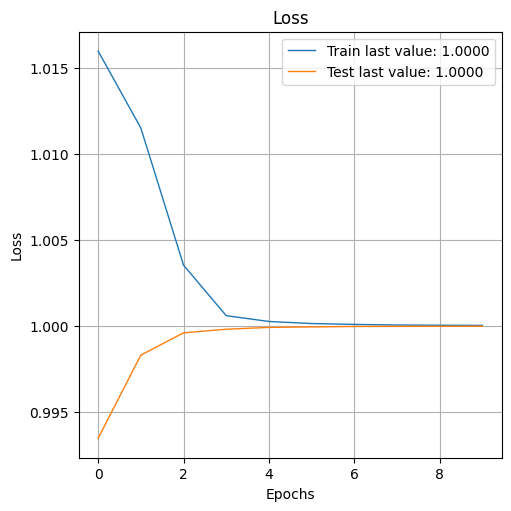

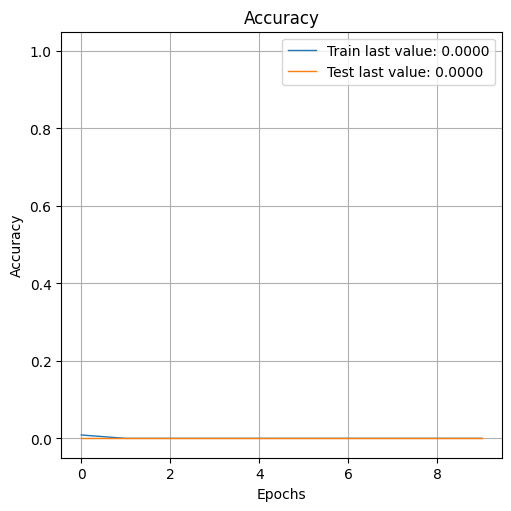

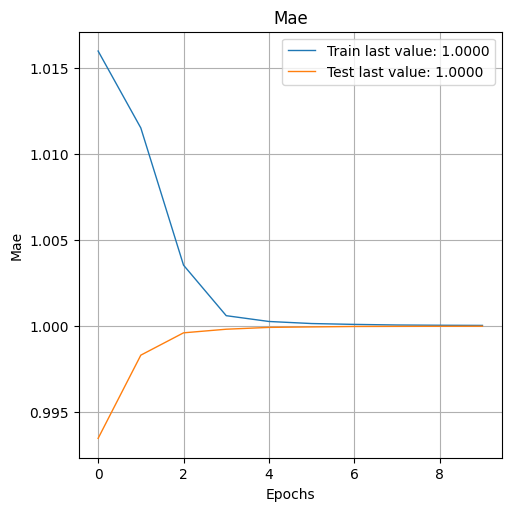

In [22]:
show_history(history_rnr)
plt.figure(figsize=(10, 10)) 
plot_history(history_rnr, single_graphs=True)
plt.close()

In [23]:
y_pred_rnr = model_rnr.predict(X_test_norm['GOOG'])

y_pred_rounded_rnr = np.where(y_pred_rnr >= 0, 1, -1)

confusion_mtx_rnr = confusion_matrix(y_test_norm['GOOG'], y_pred_rounded_rnr)

accuracy = accuracy_score(y_test_norm['GOOG'], y_pred_rounded_rnr)
print()
print("Recurrent Neuronal Network accuracy: {:.2f}%".format(accuracy * 100))

print("Confusion matrix:")
print(confusion_mtx_rnr)

44/44 [==============================] - 1s 6ms/step

Recurrent Neuronal Network accuracy: 52.90%
Confusion matrix:
[[  0 650]
 [  0 730]]


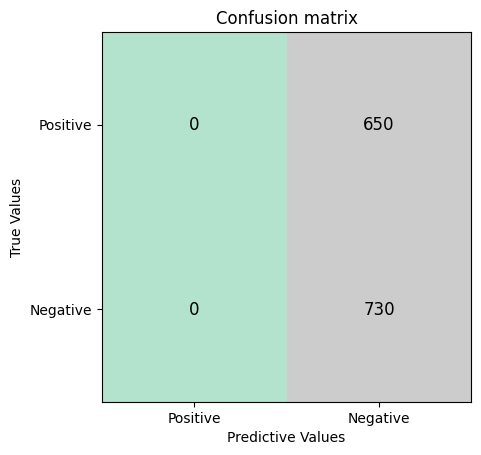

In [24]:
class_labels = ['Positive', 'Negative']

plt.imshow(confusion_mtx_rnr, cmap='Pastel2')

for i in range(confusion_mtx_rnr.shape[0]):
    for j in range(confusion_mtx_rnr.shape[1]):
        plt.text(j, i, str(confusion_mtx_rnr[i, j]), ha='center', va='center', color='black', fontsize=12)

plt.title('Confusion matrix')
plt.xlabel('Predictive Values')
plt.ylabel('True Values')
plt.xticks([0, 1], class_labels)
plt.yticks([0, 1], class_labels)
plt.show()

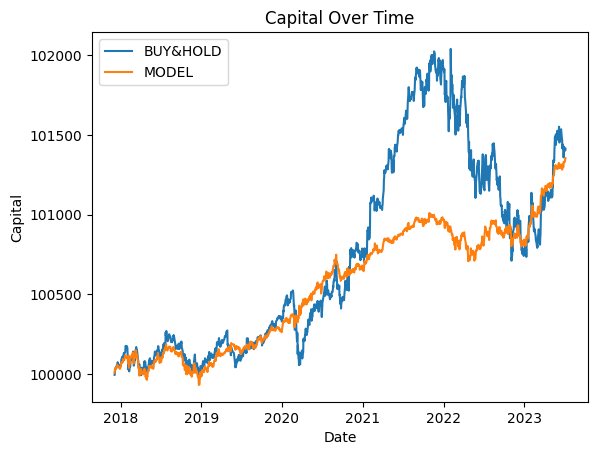

In [25]:
test_df = X_test[symbols[-1]][1:].copy()
test_df['Target'] = np.array( pd.Series(y_pred_rounded_rnr.flatten()).shift()[:-1])
test_df.dropna(inplace=True)
data_dict = {symbols[-1]: test_df}
trades_rn, portfolio = backtest(data_dict,reverse=False)
trades_rn=pd.DataFrame(trades_rn)
trades_rn=trades_rn.set_index('date')[['shares','open_price','capital']].rename(columns={'capital':'capital_RN'})

plotter(symbols,test_df)

        

## Neural Networks

In [26]:
tf.config.run_functions_eagerly(True)

X_train_reshaped = np.expand_dims(X_train_norm['GOOG'].to_numpy(), axis=1).squeeze()
X_val_reshaped = np.expand_dims(X_val_norm['GOOG'].to_numpy(), axis=1).squeeze()
X_test_reshaped = np.expand_dims(X_test_norm['GOOG'].to_numpy(), axis=1).squeeze()

model_nn = keras.Sequential([
    keras.Input(shape=X_train_norm['GOOG'].shape[1]),
    layers.Dense(200, activation='relu'),
    layers.Dense(100, activation='relu'),
    layers.Dense(50, activation='relu'),
    layers.Dense(1, activation='softmax')
])

optimizer = keras.optimizers.Adam(learning_rate=0.01)

model_nn.compile(loss='categorical_crossentropy',
                 optimizer=optimizer,
                 metrics=['categorical_accuracy', 'categorical_crossentropy','mae', 'mse'],
                 run_eagerly=True)

model_nn.summary()

history_nn = model_nn.fit(X_train_norm['GOOG'], y_train_norm['GOOG'],
                              validation_data=(X_val_reshaped, y_val_norm['GOOG']),
                              epochs=30)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 200)               12000     
                                                                 
 dense_3 (Dense)             (None, 100)               20100     
                                                                 
 dense_4 (Dense)             (None, 50)                5050      
                                                                 
 dense_5 (Dense)             (None, 1)                 51        
                                                                 
Total params: 37,201
Trainable params: 37,201
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
72/72 [==============================] - 2s 30ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - categorical_crossentropy: 0.0000e+00 - mae: 1.0330 - mse: 2.0661 

In [27]:
loss, accuracy, categorical_crossentropy, mae, mse = model_nn.evaluate(X_test_norm['GOOG'], y_test_norm['GOOG'])
print("Loss:", loss)
print("Categorical Accuracy:", accuracy)
print("Categorical Crossentropy:", categorical_crossentropy)
print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)


44/44 [==============================] - 1s 14ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - categorical_crossentropy: 0.0000e+00 - mae: 0.9420 - mse: 1.8841
Loss: 0.0
Categorical Accuracy: 1.0
Categorical Crossentropy: 0.0
Mean Absolute Error: 0.9420289993286133
Mean Squared Error: 1.8840579986572266


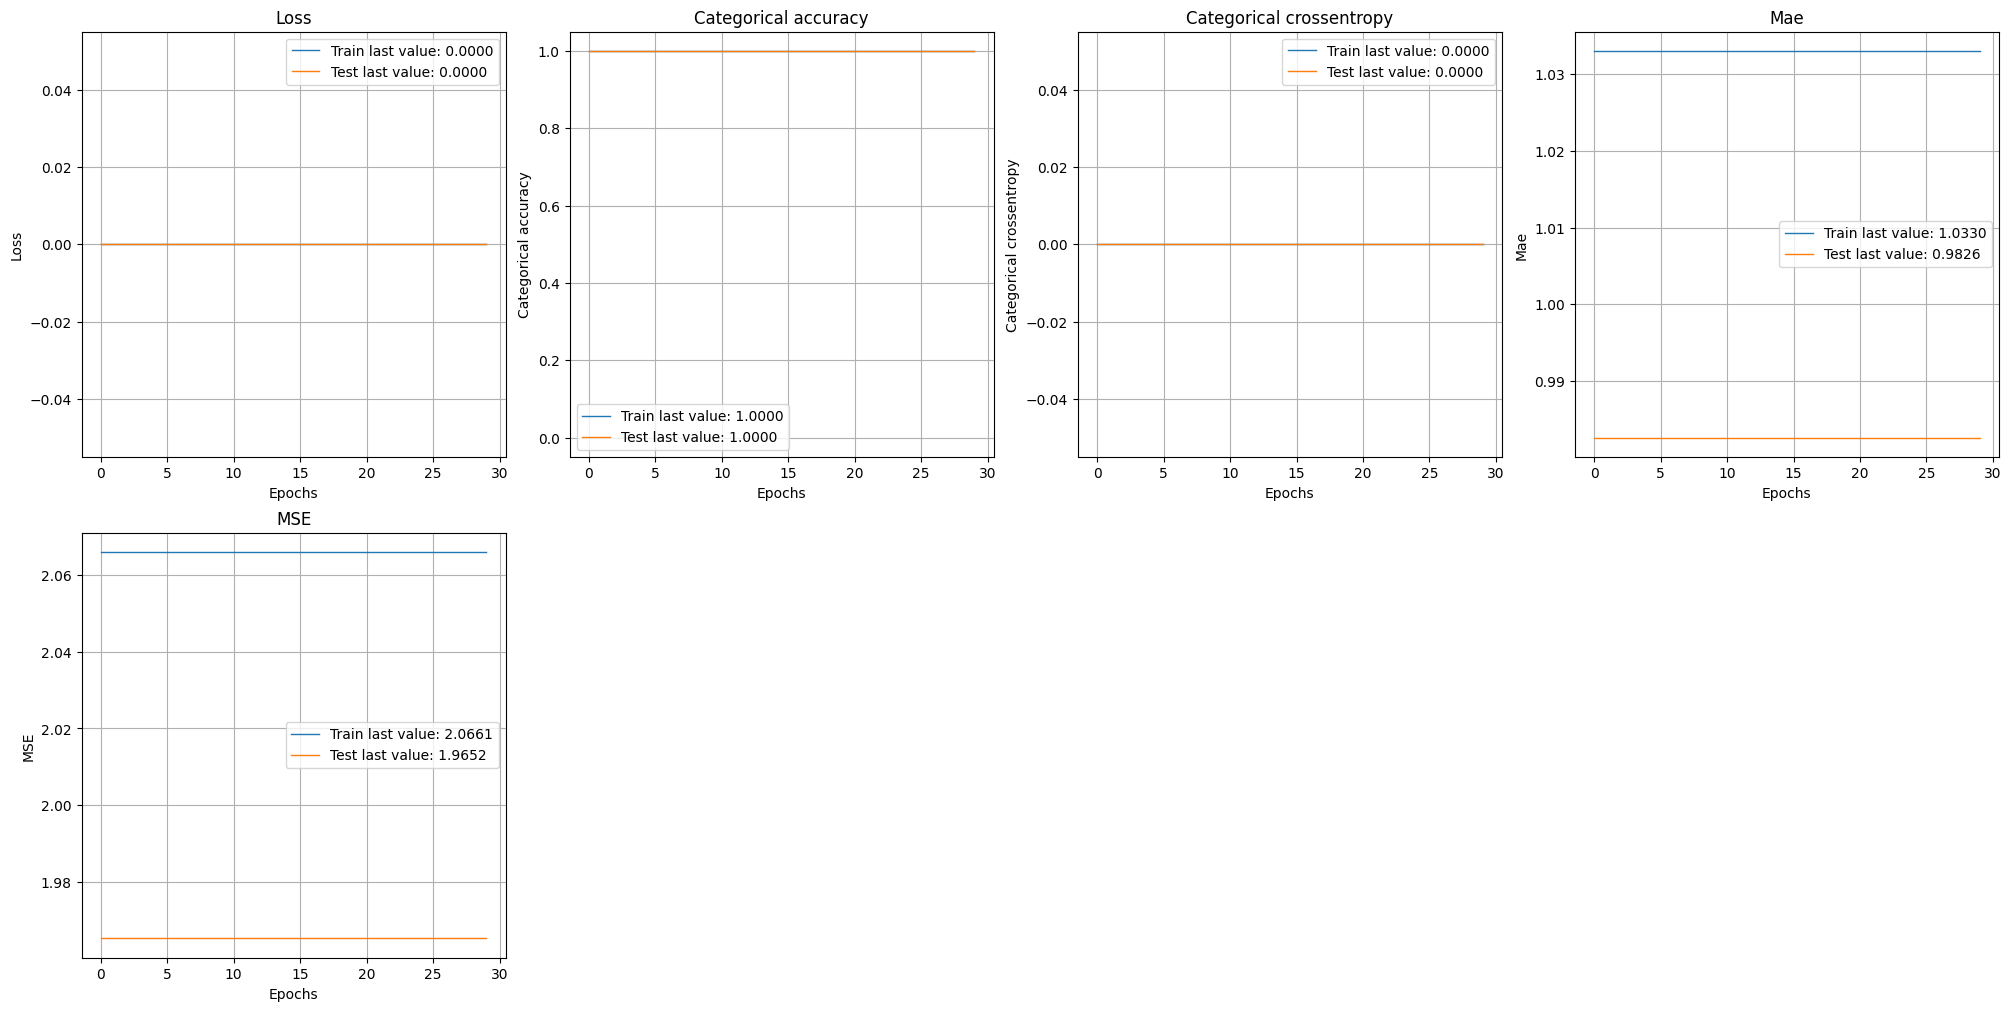

<Figure size 1000x1000 with 0 Axes>

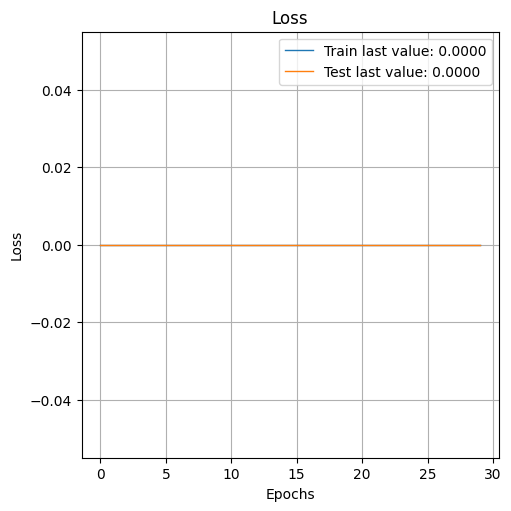

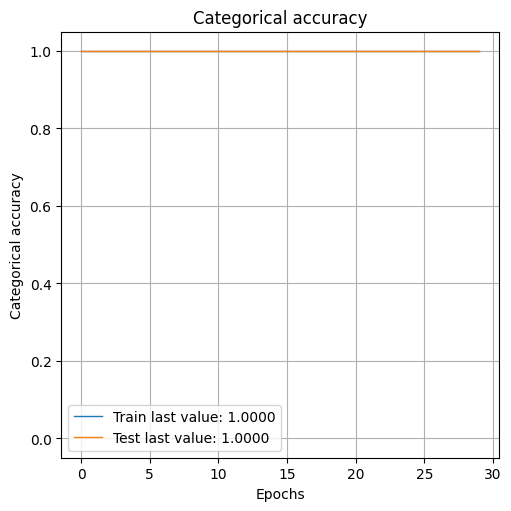

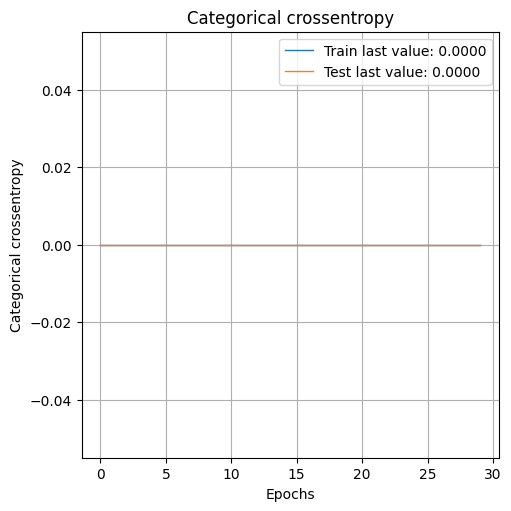

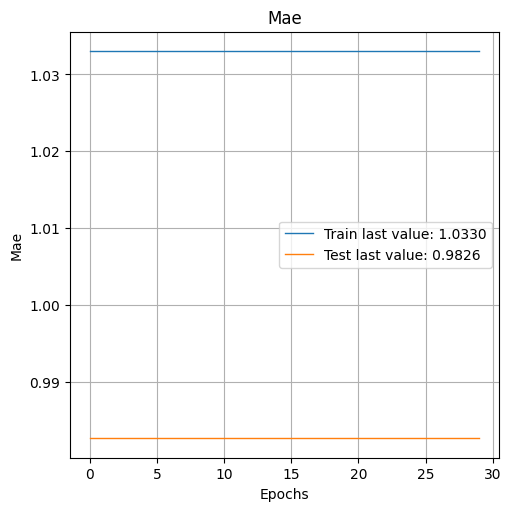

In [28]:
show_history(history_nn)
plt.figure(figsize=(10, 10)) 
plot_history(history_nn, single_graphs=True)
plt.close()

In [29]:
y_pred_rn = model_nn.predict(X_test_norm['GOOG'])

y_pred_rounded_rn = np.where(y_pred_rn >= 0, 1, -1)

confusion_mtx_rn = confusion_matrix(y_test_norm['GOOG'], y_pred_rounded_rn)

accuracy = accuracy_score(y_test_norm['GOOG'], y_pred_rounded_rn)
print()
print("Neuronal Network accuracy: {:.2f}%".format(accuracy * 100))

print("Confusion matrix:")
print(confusion_mtx_rn)

44/44 [==============================] - 0s 2ms/step

Neuronal Network accuracy: 52.90%
Confusion matrix:
[[  0 650]
 [  0 730]]


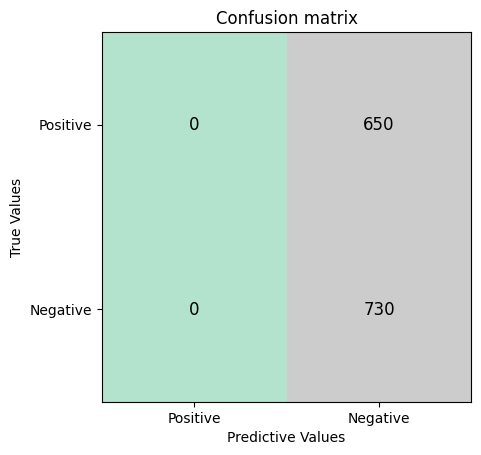

In [30]:
import matplotlib.pyplot as plt

class_labels = ['Positive', 'Negative']

plt.imshow(confusion_mtx_rn, cmap='Pastel2')

for i in range(confusion_mtx_rn.shape[0]):
    for j in range(confusion_mtx_rn.shape[1]):
        plt.text(j, i, str(confusion_mtx_rn[i, j]), ha='center', va='center', color='black', fontsize=12)

plt.title('Confusion matrix')
plt.xlabel('Predictive Values')
plt.ylabel('True Values')
plt.xticks([0, 1], class_labels)
plt.yticks([0, 1], class_labels)

plt.show()

In [31]:
test_df = X_test[symbols[-1]][1:].copy()
test_df['Target'] = np.array(pd.Series(y_pred_rounded_rn.flatten()).shift()[:-1])
test_df.dropna(inplace=True)

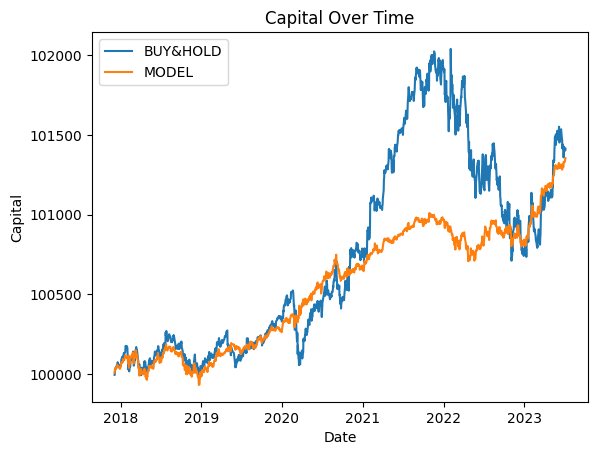

In [32]:
data_dict = {symbols[-1]: test_df}
trades, portfolio = backtest(data_dict,reverse=False)
trades_nn=pd.DataFrame(trades)
trades_nn=trades_nn.set_index('date')[['capital']].rename(columns={'capital':'capital_NN'})
trades_total = pd.concat([trades_rn,trades_nn],axis=1)

plotter(symbols,test_df)

According to the above confusion matrix, we can determine that the model, with test data never seen before, has an error of 5.3%. 

The confirmation of the return generated in the days that its prediction was not correct is missing. In the event that the decision has produced a large percentage of losses with respect to the days in which it was correct, it would invalidate the use of this model.

## Random Forest 

In [33]:
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
history_rf = model_rf.fit(X_train['GOOG'], y_train['GOOG'])
predictions = model_rf.predict(X_test['GOOG'])

accuracy = accuracy_score(y_test['GOOG'], predictions)
mae = mean_absolute_error(y_test['GOOG'], predictions)
mse = mean_squared_error(y_test['GOOG'], predictions)

print("Accuracy:", accuracy)
print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)

Accuracy: 0.8318840579710145
Mean Absolute Error: 0.336231884057971
Mean Squared Error: 0.672463768115942


In [34]:
y_pred_rf = model_rf.predict(X_test['GOOG'])

y_pred_rounded_rf = np.where(y_pred_rf >= 0, 1, -1)

confusion_mtx_rf = confusion_matrix(y_test['GOOG'], y_pred_rounded_rf)

accuracy_rf = accuracy_score(y_test['GOOG'], y_pred_rounded_rf)
print()
print("Random Forest accuracy:{:.2f}%".format(accuracy_rf * 100))

print("Matrix confusion:")
print(confusion_mtx_rf)


Random Forest accuracy:83.19%
Matrix confusion:
[[491 159]
 [ 73 657]]


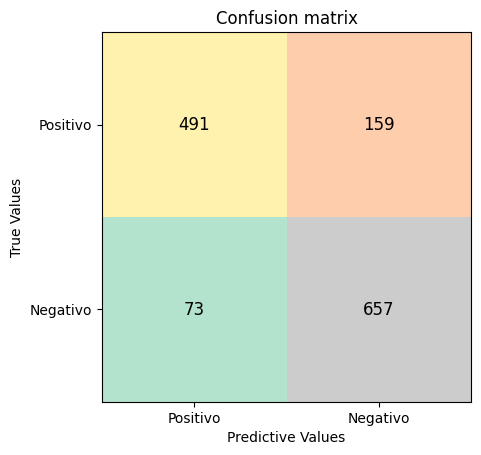

In [35]:
class_labels = ['Positivo', 'Negativo']

plt.imshow(confusion_mtx_rf, cmap='Pastel2')

for i in range(confusion_mtx_rf.shape[0]):
    for j in range(confusion_mtx_rf.shape[1]):
        plt.text(j, i, str(confusion_mtx_rf[i, j]), ha='center', va='center', color='black', fontsize=12)

plt.title('Confusion matrix')
plt.xlabel('Predictive Values')
plt.ylabel('True Values')
plt.xticks([0, 1], class_labels)
plt.yticks([0, 1], class_labels)

plt.show()

In [36]:
test_df = X_test[symbols[-1]][1:].copy()
test_df['Target'] = np.array( pd.Series(y_pred_rounded_rf).shift()[:-1])
test_df.dropna(inplace=True)

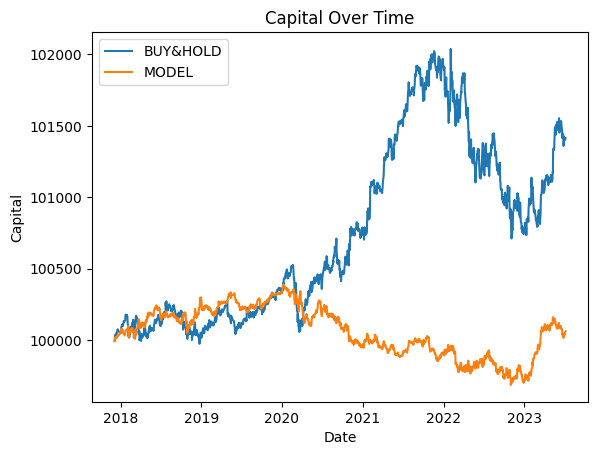

In [37]:
data_dict = {symbols[-1]: test_df}
trades_rf, portfolio = backtest(data_dict,reverse=False)
trades_rf=pd.DataFrame(trades_rf)
trades_rf=trades_rf.set_index('date')[['capital']].rename(columns={'capital':'capital_RF'})
trades_rf
trades_total = pd.concat([trades_total,trades_rf],axis=1)

plotter(symbols,test_df)

## Convolutional Neural Networks

In [38]:
def groups_generator_CNN(X,y,delta=20):
    array_x=[]
    array_y=[]
    for i in range(len(X)-delta+1):
        array_x.append(X[i:i+delta])
        array_y.append(y[i+delta-1])
    
    array_x=np.array(array_x)
    array_y=np.array(array_y)
    print(array_x.shape)
    array_x=array_x.reshape((array_x.shape[0], delta, 59))
    array_y = array_y.reshape((array_y.shape[0], 1))
    return array_x,array_y

In [39]:
X_train_norm['GOOG'].reset_index(drop=True)

,Open,Adj_open,High,Adj_high,Low,Adj_low,Close,Adj_close,Volume,Percentage,...,CDLDRAGONFLYDOJI,CDLENGULFING,CDLEVENINGDOJISTAR,CDLEVENINGSTAR,CDLGAPSIDESIDEWHITE,Target_1,Target_2,Target_3,Target_4,Target_5
0,0.006395,0.006395,0.006113,0.006113,0.006761,0.006761,0.006229,0.006229,0.162807,-0.341694,...,0.0,0.5,1.0,1.0,0.5,0.0,1.0,0.0,1.0,0.0
1,0.006290,0.006290,0.006351,0.006351,0.006854,0.006854,0.006527,0.006527,0.171739,1.409558,...,0.0,1.0,1.0,1.0,0.5,1.0,0.0,1.0,0.0,1.0
2,0.006590,0.006590,0.006318,0.006318,0.006933,0.006933,0.006338,0.006338,0.134663,-0.713679,...,0.0,0.5,1.0,1.0,0.5,0.0,1.0,0.0,1.0,0.0
3,0.006304,0.006304,0.006181,0.006181,0.006398,0.006398,0.005923,0.005923,0.127390,-1.270060,...,0.0,0.5,1.0,1.0,0.5,0.0,0.0,1.0,0.0,1.0
4,0.005877,0.005877,0.005973,0.005973,0.006322,0.006322,0.006283,0.006283,0.141918,2.201737,...,0.0,1.0,1.0,1.0,0.5,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2295,0.184049,0.184049,0.184036,0.184036,0.186467,0.186467,0.185534,0.185534,0.041273,0.080626,...,0.0,0.5,1.0,1.0,0.5,1.0,0.0,1.0,1.0,1.0
2296,0.184828,0.184828,0.184533,0.184533,0.186909,0.186909,0.185480,0.185480,0.045201,-0.332833,...,0.0,0.5,1.0,1.0,0.5,0.0,1.0,0.0,1.0,1.0
2297,0.184419,0.184419,0.186246,0.186246,0.187291,0.187291,0.186945,0.186945,0.040629,0.593180,...,0.0,0.5,1.0,1.0,0.5,1.0,0.0,1.0,0.0,1.0
2298,0.186183,0.186183,0.186969,0.186969,0.188189,0.188189,0.188204,0.188204,0.034898,0.333895,...,0.0,0.5,1.0,1.0,0.5,1.0,1.0,0.0,1.0,0.0


In [40]:
X_CNNtrain,y_CNNtrain = groups_generator_CNN(X_train_norm['GOOG'],y_train_norm['GOOG'])
X_CNNtest,y_CNNtest = groups_generator_CNN(X_test_norm['GOOG'],y_test_norm['GOOG'])
X_CNNval,y_CNNval = groups_generator_CNN(X_val_norm['GOOG'],y_val_norm['GOOG'])

(2281, 20, 59)
(1361, 20, 59)
(901, 20, 59)


### Convolutional Model 2D

In [41]:
#CNN model
model_cnn_2D = Sequential()
model_cnn_2D.add(Conv2D(50, (3, 3), activation='relu', input_shape=(20, 59, 1)))
model_cnn_2D.add(MaxPooling2D((2, 2)))
model_cnn_2D.add(Conv2D(100, (3, 3), activation='relu'))
model_cnn_2D.add(MaxPooling2D((2, 2)))
model_cnn_2D.add(Conv2D(200, (3, 3), activation='relu'))
model_cnn_2D.add(Flatten())
model_cnn_2D.add(Dense(128, activation='relu'))
model_cnn_2D.add(Dense(1, activation='tanh'))
model_cnn_2D.summary()



Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 18, 57, 50)        500       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 9, 28, 50)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 26, 100)        45100     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 3, 13, 100)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 1, 11, 200)        180200    
                                                                 
 flatten (Flatten)           (None, 2200)             

In [42]:
optimizer = keras.optimizers.Adam(learning_rate=0.0005)

model_cnn_2D.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['accuracy', 'mae', 'mse'])
history_cnn_2D = model_cnn_2D.fit(X_CNNtrain, y_CNNtrain, validation_data=(X_CNNval, y_CNNval), epochs=30)

loss, accuracy, mae, mse = model_cnn_2D.evaluate(X_CNNtest, y_CNNtest)
print("Loss:", loss)
print("Accuracy:", accuracy)
print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)

Epoch 1/30
72/72 [==============================] - 9s 124ms/step - loss: 1.0065 - accuracy: 0.0000e+00 - mae: 0.9983 - mse: 1.0065 - val_loss: 1.0105 - val_accuracy: 0.0000e+00 - val_mae: 1.0021 - val_mse: 1.0105
Epoch 2/30
72/72 [==============================] - 9s 122ms/step - loss: 1.0004 - accuracy: 0.0000e+00 - mae: 0.9986 - mse: 1.0004 - val_loss: 1.0025 - val_accuracy: 0.0000e+00 - val_mae: 1.0007 - val_mse: 1.0025
Epoch 3/30
72/72 [==============================] - 9s 124ms/step - loss: 0.9991 - accuracy: 0.0000e+00 - mae: 0.9980 - mse: 0.9991 - val_loss: 1.0022 - val_accuracy: 0.0000e+00 - val_mae: 1.0008 - val_mse: 1.0022
Epoch 4/30
72/72 [==============================] - 9s 123ms/step - loss: 0.9956 - accuracy: 0.0000e+00 - mae: 0.9950 - mse: 0.9956 - val_loss: 0.9999 - val_accuracy: 0.0000e+00 - val_mae: 0.9997 - val_mse: 0.9999
Epoch 5/30
72/72 [==============================] - 9s 122ms/step - loss: 0.9931 - accuracy: 0.0000e+00 - mae: 0.9923 - mse: 0.9931 - val_loss: 

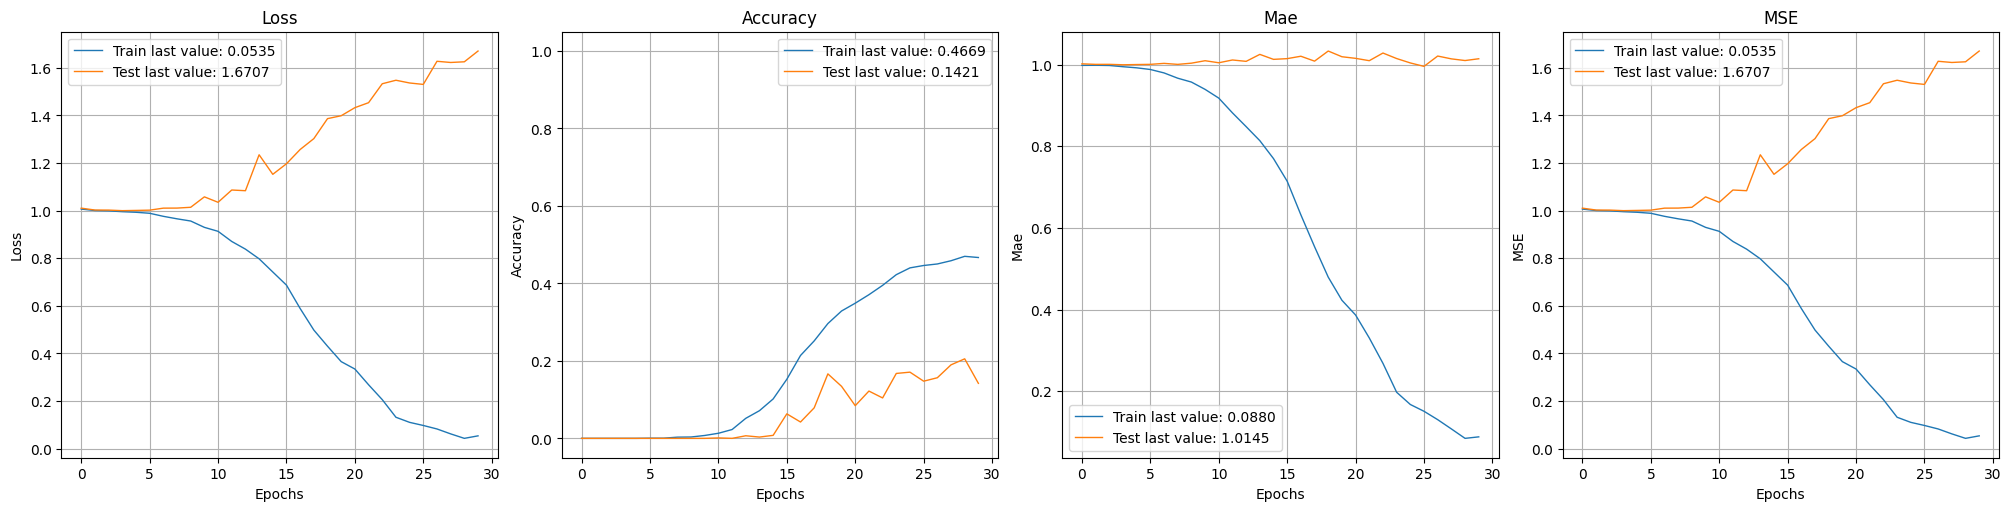

<Figure size 1000x1000 with 0 Axes>

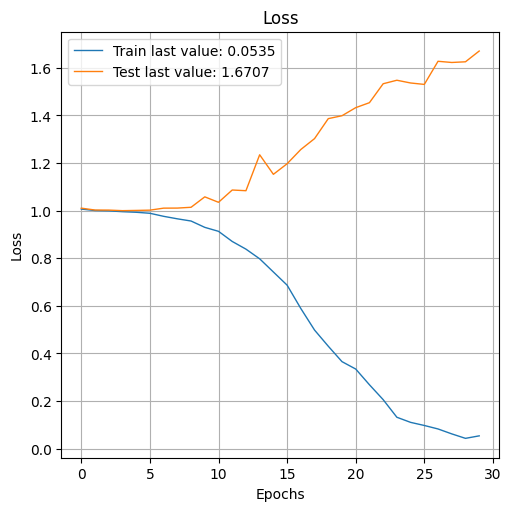

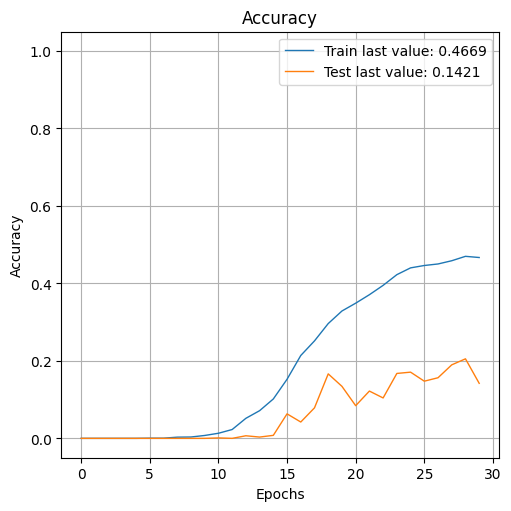

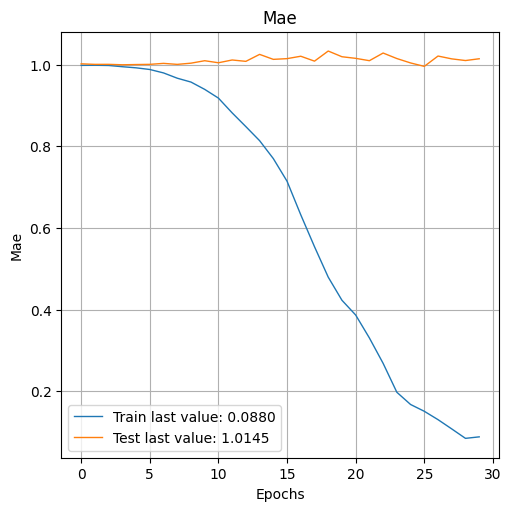

In [43]:
show_history(history_cnn_2D)
plt.figure(figsize=(10, 10)) 
plot_history(history_cnn_2D, single_graphs=True)
plt.close()

In [44]:
y_CNNpred_2D = model_cnn_2D.predict(X_CNNtest)

y_CNNpred_round_2D = np.where(y_CNNpred_2D >= 0, 1, -1)

confusion_mtx_cnn_2D = confusion_matrix(y_CNNtest, y_CNNpred_round_2D)

accuracy_cnn_2D = accuracy_score(y_CNNtest, y_CNNpred_round_2D)
print()
print("Convolutional Neuronal Networks accuracy: {:.2f}%".format(accuracy_cnn_2D * 100))

print("Confusion matrix:")
print(confusion_mtx_cnn_2D)

43/43 [==============================] - 1s 28ms/step

Convolutional Neuronal Networks accuracy: 47.76%
Confusion matrix:
[[357 282]
 [429 293]]


(array([500., 101.,  65.,  65.,  55.,  43.,  67.,  78.,  85., 302.]),
 array([-1.00000000e+00, -8.00002277e-01, -6.00004554e-01, -4.00006801e-01,
        -2.00009078e-01, -1.13546848e-05,  1.99986368e-01,  3.99984092e-01,
         5.99981844e-01,  7.99979568e-01,  9.99977291e-01]),
 <BarContainer object of 10 artists>)

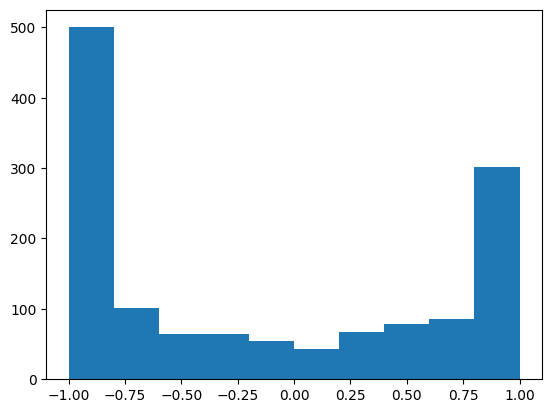

In [45]:
plt.hist(y_CNNpred_2D)

In [46]:
y_CNNtrainpred_2d = np.where(model_cnn_2D.predict(X_CNNtrain) >= 0, 1, -1)
y_CNNvalpred_2d =  np.where(model_cnn_2D.predict(X_CNNval) >= 0, 1, -1)
y_CNNtestpred_2d = np.where(model_cnn_2D.predict(X_CNNtest) >= 0, 1, -1)

print(f"Precisión train:", accuracy_score(y_CNNtrain, y_CNNtrainpred_2d))
print(f"Error cuadrático medio (MSE): {mean_squared_error(y_CNNtrain, y_CNNtrainpred_2d)}\n\n")

print(f"Precisión val:", accuracy_score(y_CNNval, y_CNNvalpred_2d))
print(f"Error cuadrático medio (MSE): {mean_squared_error(y_CNNval, y_CNNvalpred_2d)}\n\n")

print(f"Precisión test:", accuracy_score(y_CNNtest, y_CNNtestpred_2d))
print(f"Error cuadrático medio (MSE): {mean_squared_error(y_CNNtest, y_CNNtestpred_2d)}\n\n")

43/43 [==============================] - 1s 28ms/step
Precisión train: 0.9938623410784744
Error cuadrático medio (MSE): 0.024550635686102586


Precisión val: 0.5016648168701443
Error cuadrático medio (MSE): 1.9933407325194228


Precisión test: 0.4775900073475386
Error cuadrático medio (MSE): 2.089639970609846




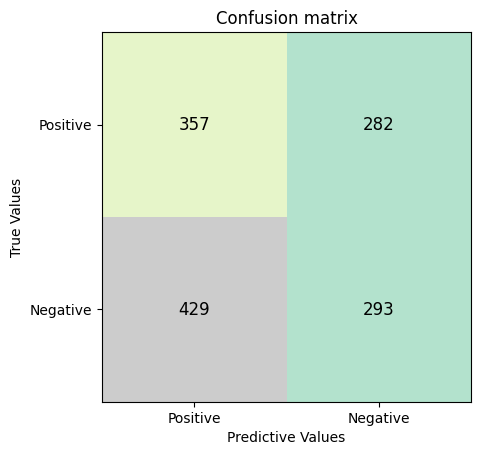

In [47]:
class_labels = ['Positive', 'Negative']

plt.imshow(confusion_mtx_cnn_2D, cmap='Pastel2')

for i in range(confusion_mtx_cnn_2D.shape[0]):
    for j in range(confusion_mtx_cnn_2D.shape[1]):
        plt.text(j, i, str(confusion_mtx_cnn_2D[i, j]), ha='center', va='center', color='black', fontsize=12)

plt.title('Confusion matrix')
plt.xlabel('Predictive Values')
plt.ylabel('True Values')
plt.xticks([0, 1], class_labels)
plt.yticks([0, 1], class_labels)
plt.show()

In [48]:
test_df = X_test[symbols[-1]][20:].copy()
test_df['Target'] = np.array(pd.Series(y_CNNtestpred_2d.flatten()).shift()[:-1])
test_df.dropna(inplace=True)

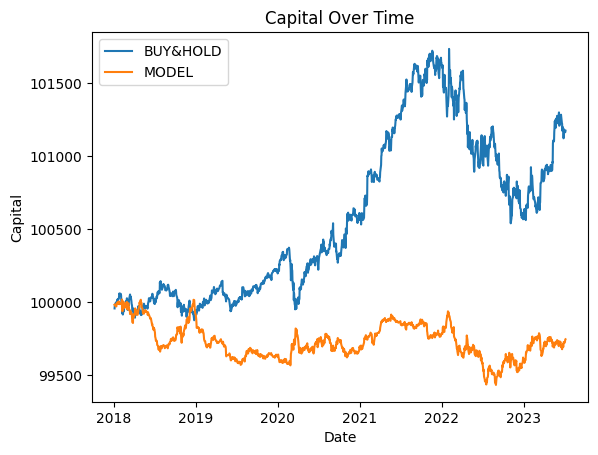

In [49]:
data_dict = {symbols[-1]: test_df}
trades_cnn_2D, portfolio = backtest(data_dict,reverse=False)
trades_cnn_2D=pd.DataFrame(trades_cnn_2D)
trades_cnn_2D=trades_cnn_2D.set_index('date')[['capital']].rename(columns={'capital':'capital_CNN_2D'})

trades_total = pd.concat([trades_total,trades_cnn_2D],axis=1)

plotter(symbols,test_df)

### Convolutional Model 1D

In [50]:
def groups_generator_CNN(X, y, delta=20):
    array_x = []
    array_y = []
    for i in range(len(X) - delta + 1):
        array_x.append(X[i:i + delta])
        array_y.append(y[i + delta - 1])
    

    array_x = np.array(array_x)
    array_y = np.array(array_y)
    print(array_x.shape)
    array_x = array_x.reshape((array_x.shape[0],delta,59))
    array_y = array_y.reshape((array_y.shape[0], 1))
    return array_x, array_y

# Data preparation
X_CNNtrain,y_CNNtrain = groups_generator_CNN(X_train_norm['GOOG'],y_train_norm['GOOG'])
X_CNNtest,y_CNNtest = groups_generator_CNN(X_test_norm['GOOG'],y_test_norm['GOOG'])
X_CNNval,y_CNNval = groups_generator_CNN(X_val_norm['GOOG'],y_val_norm['GOOG'])

(2281, 20, 59)
(1361, 20, 59)
(901, 20, 59)


In [51]:
model_cnn = Sequential()
model_cnn.add(Conv1D(50, 3, activation='relu', input_shape=(20,59)))
model_cnn.add(MaxPooling1D(2))
model_cnn.add(Conv1D(100, 3, activation='relu'))
model_cnn.add(MaxPooling1D(2))
model_cnn.add(Conv1D(200, 3, activation='relu'))
model_cnn.add(Flatten())
model_cnn.add(Dense(128, activation='relu'))
model_cnn.add(Dense(1, activation='tanh'))
model_cnn.summary()

optimizer = keras.optimizers.Adam(learning_rate=0.0005)

model_cnn.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['accuracy', 'mae', 'mse'])
history_cnn = model_cnn.fit(X_CNNtrain, y_CNNtrain, validation_data=(X_CNNval, y_CNNval), epochs=50, batch_size=32)

loss, accuracy, mae, mse = model_cnn.evaluate(X_CNNtest, y_CNNtest)
print("Loss:", loss)
print("Accuracy:", accuracy)
print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 18, 50)            8900      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 9, 50)            0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 7, 100)            15100     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 3, 100)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 1, 200)            60200     
                                                                 
 flatten_1 (Flatten)         (None, 200)              

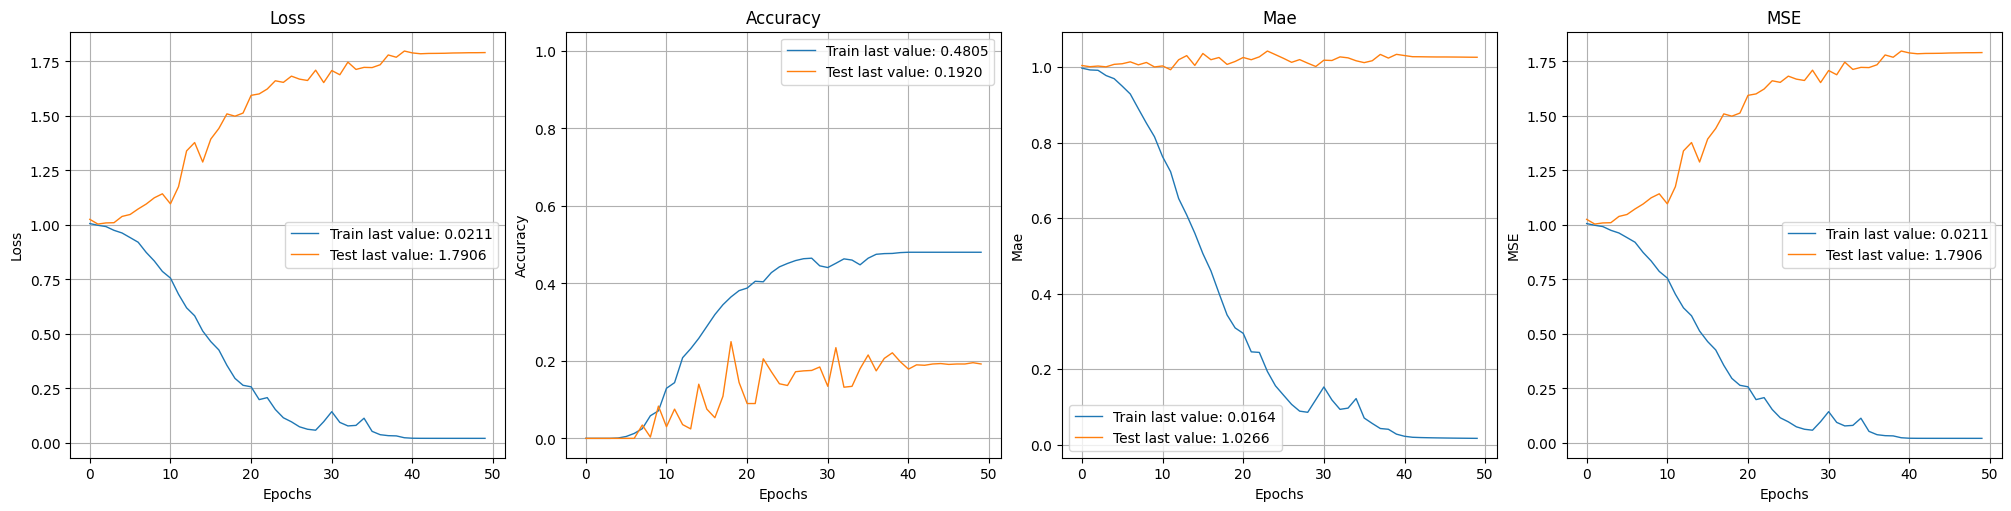

<Figure size 1000x1000 with 0 Axes>

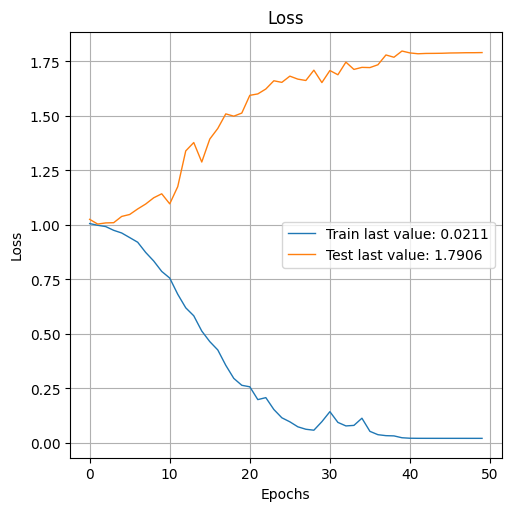

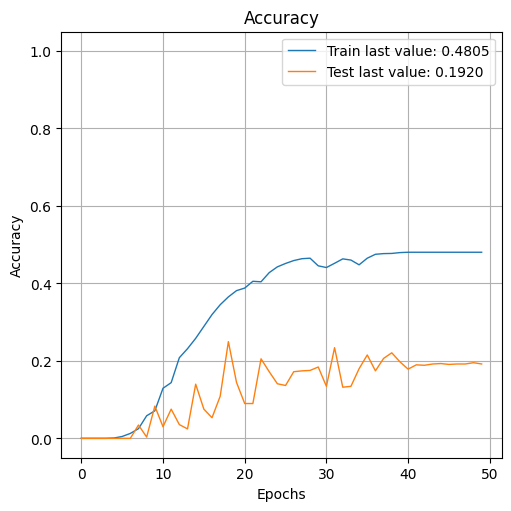

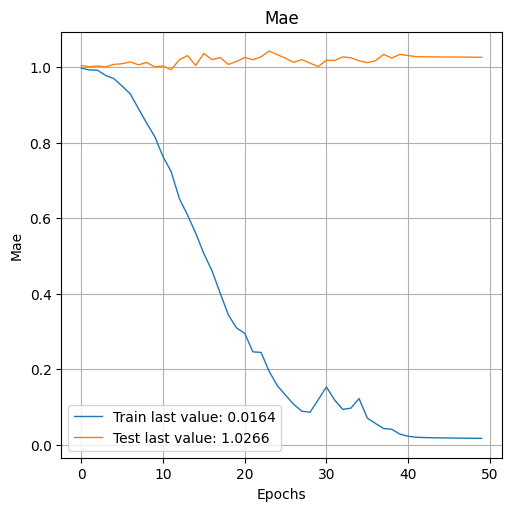

In [93]:
show_history(history_cnn)
plt.figure(figsize=(10, 10)) 
plot_history(history_cnn, single_graphs=True)
plt.close()

In [54]:
y_CNNpred = model_cnn.predict(X_CNNtest)

y_CNNpred_round = np.where(y_CNNpred >= 0, 1, -1)

confusion_mtx_cnn = confusion_matrix(y_CNNtest, y_CNNpred_round)

accuracy_cnn = accuracy_score(y_CNNtest, y_CNNpred_round)
print()
print("Convolutional Neuronal Networks accuracy: {:.2f}%".format(accuracy_cnn * 100))

print("Confusion matrix:")
print(confusion_mtx_cnn)

43/43 [==============================] - 0s 6ms/step

Convolutional Neuronal Networks accuracy: 49.74%
Confusion matrix:
[[397 242]
 [442 280]]


(array([666.,  62.,  47.,  39.,  25.,  34.,  28.,  38.,  65., 357.]),
 array([-1.        , -0.80000001, -0.60000002, -0.40000001, -0.2       ,
         0.        ,  0.2       ,  0.40000001,  0.60000002,  0.80000001,
         1.        ]),
 <BarContainer object of 10 artists>)

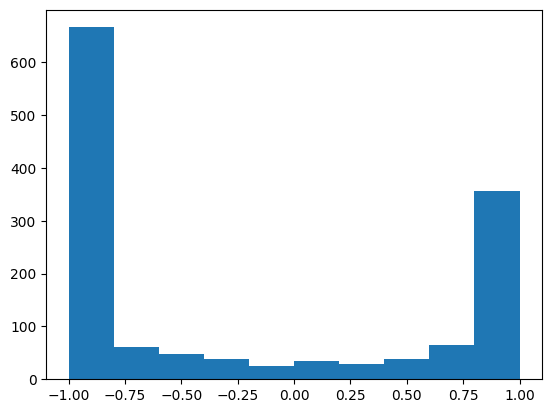

In [55]:
plt.hist(y_CNNpred)

In [56]:
y_CNNtrainpred = np.where(model_cnn.predict(X_CNNtrain) >= 0, 1, -1)
y_CNNvalpred =  np.where(model_cnn.predict(X_CNNval) >= 0, 1, -1)
y_CNNtestpred = np.where(model_cnn.predict(X_CNNtest) >= 0, 1, -1)

print(f"Precisión train:", accuracy_score(y_CNNtrain, y_CNNtrainpred))
print(f"Error cuadrático medio (MSE): {mean_squared_error(y_CNNtrain, y_CNNtrainpred)}\n\n")

print(f"Precisión val:", accuracy_score(y_CNNval, y_CNNvalpred))
print(f"Error cuadrático medio (MSE): {mean_squared_error(y_CNNtrain, y_CNNtrainpred)}\n\n")

print(f"Precisión test:", accuracy_score(y_CNNtest, y_CNNtestpred))
print(f"Error cuadrático medio (MSE): {mean_squared_error(y_CNNtrain, y_CNNtrainpred)}\n\n")


43/43 [==============================] - 0s 6ms/step
Precisión train: 0.9947391494958352
Error cuadrático medio (MSE): 0.02104340201665936


Precisión val: 0.47835738068812433
Error cuadrático medio (MSE): 0.02104340201665936


Precisión test: 0.49742836149889785
Error cuadrático medio (MSE): 0.02104340201665936




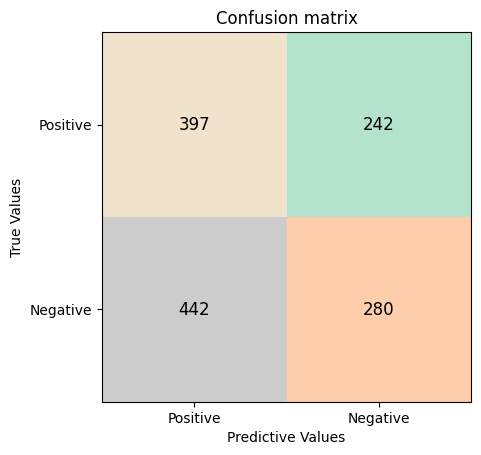

In [57]:
class_labels = ['Positive', 'Negative']

plt.imshow(confusion_mtx_cnn, cmap='Pastel2')

for i in range(confusion_mtx_cnn.shape[0]):
    for j in range(confusion_mtx_cnn.shape[1]):
        plt.text(j, i, str(confusion_mtx_cnn[i, j]), ha='center', va='center', color='black', fontsize=12)

plt.title('Confusion matrix')
plt.xlabel('Predictive Values')
plt.ylabel('True Values')
plt.xticks([0, 1], class_labels)
plt.yticks([0, 1], class_labels)
plt.show()

In [58]:
test_df = X_test[symbols[-1]][20:].copy()
test_df['Target'] = np.array(pd.Series(y_CNNtestpred.flatten()).shift()[:-1])
test_df.dropna(inplace=True)

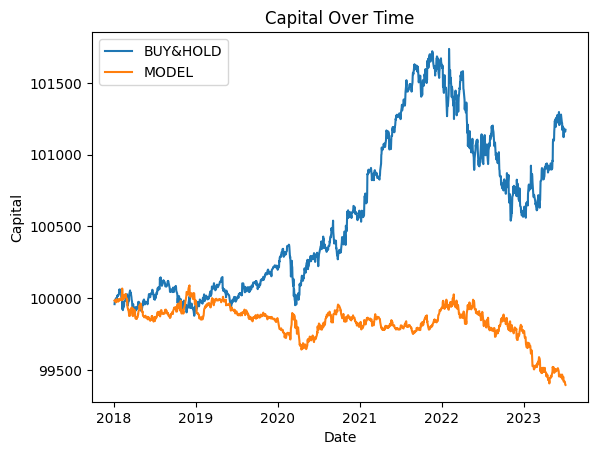

In [59]:
data_dict = {symbols[-1]: test_df}
trades_cnn, portfolio = backtest(data_dict,reverse=False)
trades_cnn=pd.DataFrame(trades_cnn)
trades_cnn=trades_cnn.set_index('date')[['capital']].rename(columns={'capital':'capital_CNN_1D'})

trades_total = pd.concat([trades_total,trades_cnn],axis=1)

plotter(symbols,test_df)

## Support Vector Machine

In [60]:
y_pred= {}
model_svm = tf.keras.Sequential([
    tf.keras.layers.Dense(1, activation='linear')
])

loss_fn = tf.keras.losses.Hinge()
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)

model_svm.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy', 'mae', 'mse'])

history_svm = model_svm.fit(X_train['GOOG'], y_train['GOOG'],validation_data=(X_val['GOOG'], y_val['GOOG']), epochs=10, batch_size=16)

loss,accuracy, mae, mse = model_svm.evaluate(X_test['GOOG'], y_test['GOOG'])
print("Loss:", loss)
print("Accuracy:", accuracy)
print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)

Epoch 1/10
144/144 [==============================] - 2s 17ms/step - loss: 13906198940090368.0000 - accuracy: 0.2257 - mae: 26788172734136320.0000 - mse: 1151212513384377558936508560310272.0000 - val_loss: 18097589878521856.0000 - val_accuracy: 0.5087 - val_mae: 37089460667547648.0000 - val_mse: 1391070282037388512125993005088768.0000
Epoch 2/10
144/144 [==============================] - 2s 16ms/step - loss: 13994011693940736.0000 - accuracy: 0.2230 - mae: 26714196217430016.0000 - mse: 1069916836262001725611348710129664.0000 - val_loss: 11048526343569408.0000 - val_accuracy: 0.5087 - val_mae: 22643430509248512.0000 - val_mse: 518487703279561333584408688459776.0000
Epoch 3/10
144/144 [==============================] - 2s 16ms/step - loss: 13433272574935040.0000 - accuracy: 0.2274 - mae: 26389621243904000.0000 - mse: 1090660069045277378842627160408064.0000 - val_loss: 11833129895460864.0000 - val_accuracy: 0.0000e+00 - val_mae: 23111972786536448.0000 - val_mse: 54010851949381163842618984

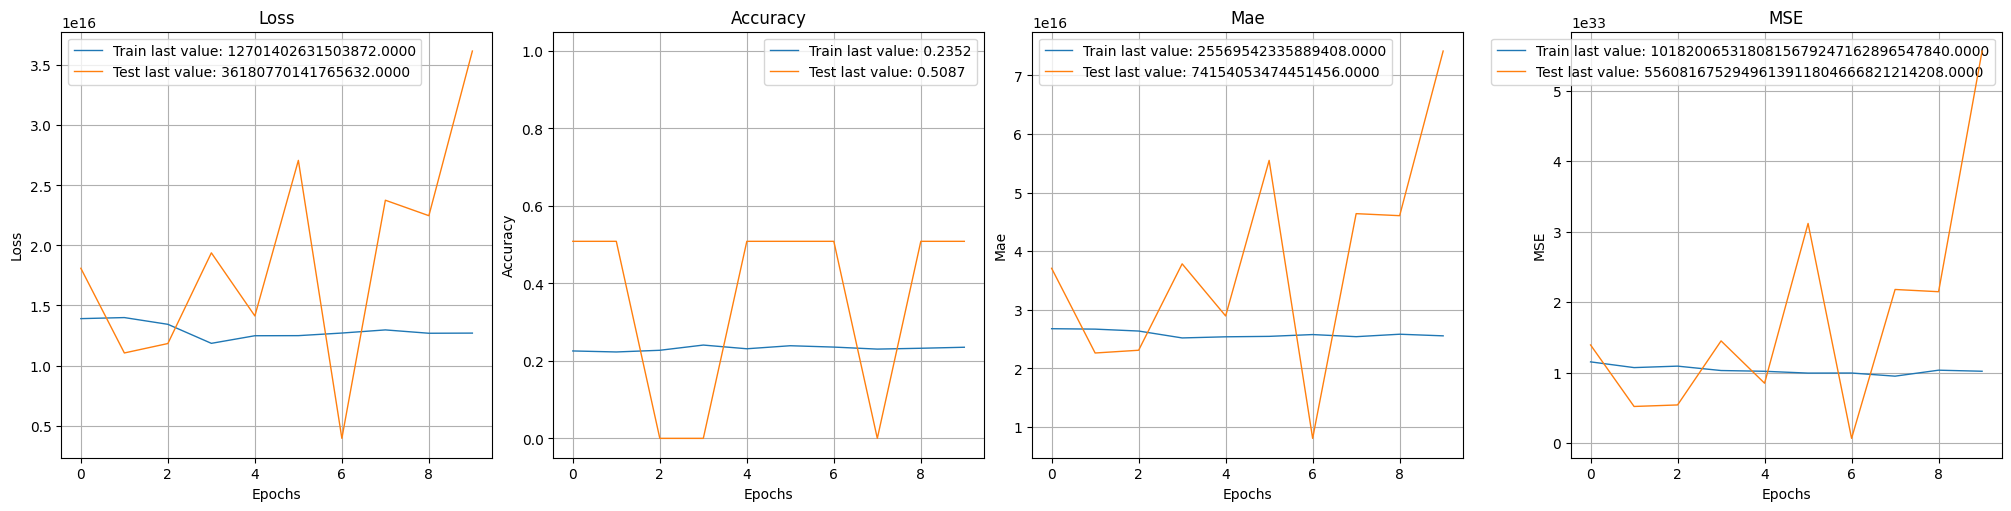

<Figure size 1000x1000 with 0 Axes>

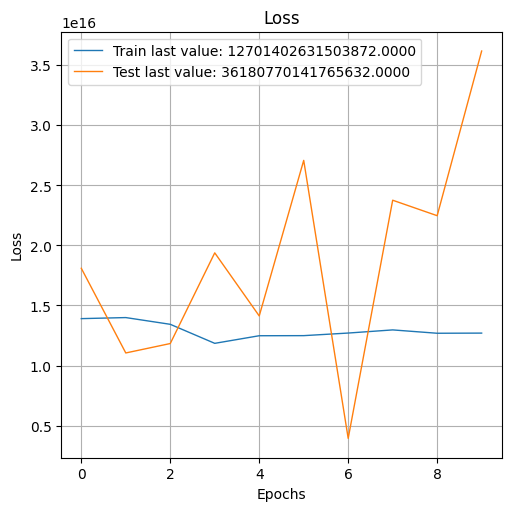

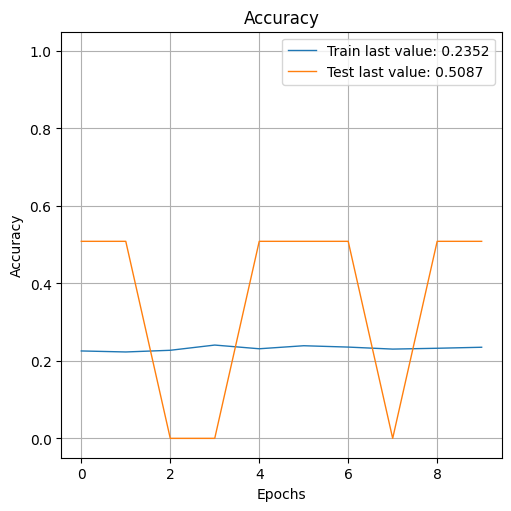

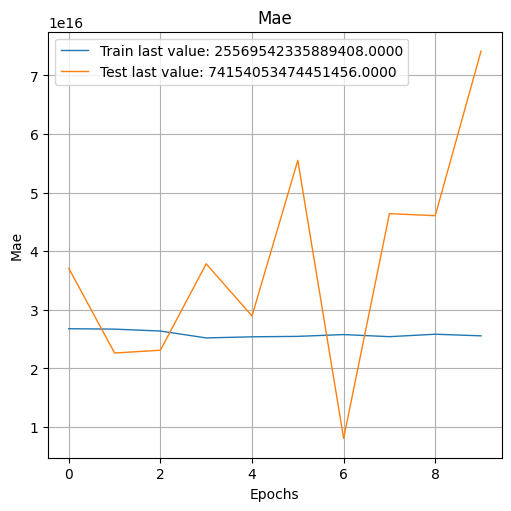

In [61]:
show_history(history_svm)
plt.figure(figsize=(10, 10)) 
plot_history(history_svm, single_graphs=True)
plt.close()

In [62]:
y_pred_svm = model_svm.predict(X_test['GOOG'])

y_pred_rounded_svm = np.where(y_pred_svm >= 0, 1, -1)

confusion_mtx_svm = confusion_matrix(y_test['GOOG'], y_pred_rounded_svm)

accuracy_svm = accuracy_score(y_test['GOOG'], y_pred_rounded_svm)
print()
print("Support Vector Machine accuracy: {:.2f}%".format(accuracy_svm * 100))

print("Confusion matrix:")
print(confusion_mtx_svm)

44/44 [==============================] - 0s 1ms/step

Support Vector Machine accuracy: 52.90%
Confusion matrix:
[[  0 650]
 [  0 730]]


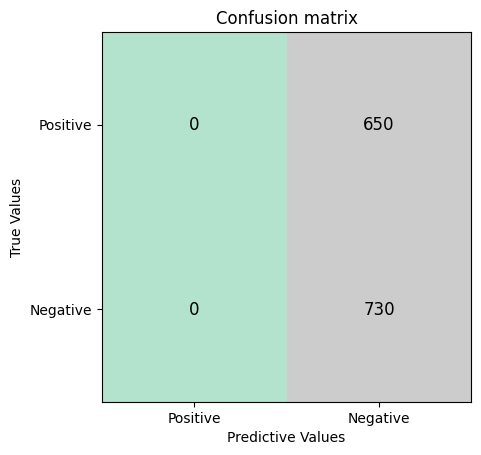

In [63]:
class_labels = ['Positive', 'Negative']

plt.imshow(confusion_mtx_svm, cmap='Pastel2')

for i in range(confusion_mtx_svm.shape[0]):
    for j in range(confusion_mtx_svm.shape[1]):
        plt.text(j, i, str(confusion_mtx_svm[i, j]), ha='center', va='center', color='black', fontsize=12)

plt.title('Confusion matrix')
plt.xlabel('Predictive Values')
plt.ylabel('True Values')
plt.xticks([0, 1], class_labels)
plt.yticks([0, 1], class_labels)

plt.show()

In [64]:
test_df = X_test[symbols[-1]][1:].copy()
test_df['Target'] = np.array(pd.Series(y_pred_rounded_svm.flatten()).shift()[:-1])
test_df.dropna(inplace=True)

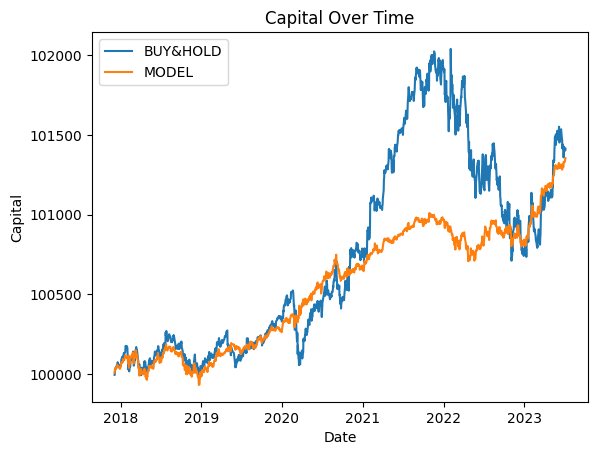

In [65]:
data_dict = {symbols[-1]: test_df}
trades_svm, portfolio = backtest(data_dict,reverse=False)
trades_svm=pd.DataFrame(trades_svm)
trades_svm=trades_svm.set_index('date')[['capital']].rename(columns={'capital':'capital_SVM'})

trades_total = pd.concat([trades_total,trades_svm],axis=1)

plotter(symbols,test_df)

## Overview

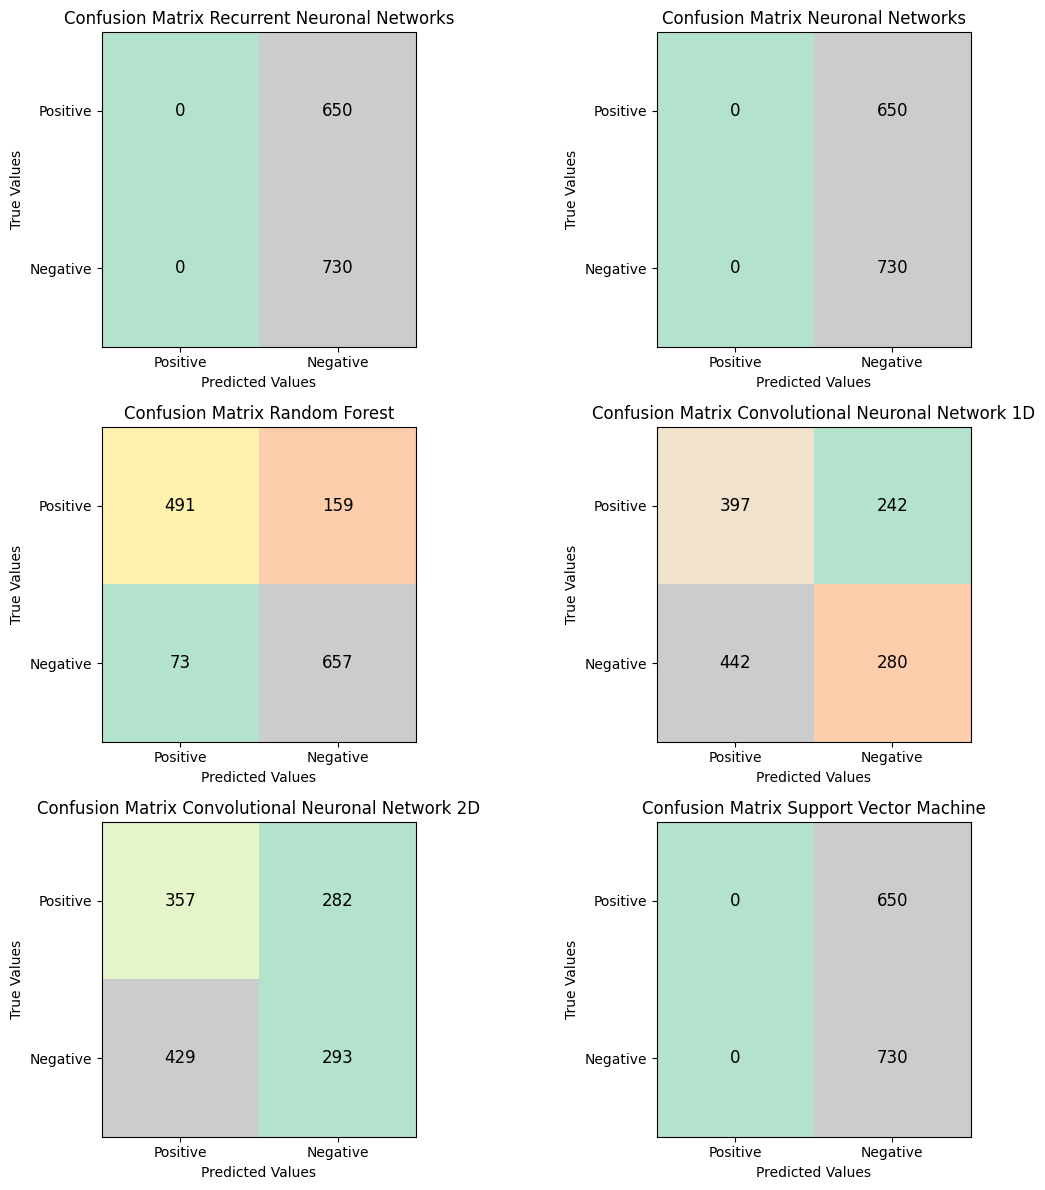

In [66]:
import matplotlib.pyplot as plt

class_labels = ['Positive', 'Negative']

fig, axs = plt.subplots(3, 2, figsize=(12, 12))

matrix_confusion = [confusion_mtx_rnr, confusion_mtx_rn, confusion_mtx_rf, confusion_mtx_cnn,confusion_mtx_cnn_2D, confusion_mtx_svm]
titles = ['Recurrent Neuronal Networks', 'Neuronal Networks', 'Random Forest', 'Convolutional Neuronal Network 1D','Convolutional Neuronal Network 2D' ,'Support Vector Machine']

for i, ax in enumerate(axs.flatten()):
    if i < len(matrix_confusion):
        
        ax.imshow(matrix_confusion[i], cmap='Pastel2')

        for x in range(matrix_confusion[i].shape[0]):
            for y in range(matrix_confusion[i].shape[1]):
                ax.text(y, x, str(matrix_confusion[i][x, y]), ha='center', va='center', color='black', fontsize=12)

        ax.set_title('Confusion Matrix ' + titles[i])
        ax.set_xlabel('Predicted Values')
        ax.set_ylabel('True Values')
        ax.set_xticks([0, 1])
        ax.set_yticks([0, 1])
        ax.set_xticklabels(class_labels)
        ax.set_yticklabels(class_labels)
    else:
        
        ax.axis('off')

# Ajustar el espaciado entre los subgráficos
plt.tight_layout()

plt.show()


In [67]:
trades_total

,shares,open_price,capital_RN,capital_NN,capital_RF,capital_CNN_2D,capital_CNN_1D,capital_SVM
date,,,,,,,,
2017-12-05,20,49.797001,100009.209976,100009.209976,99990.790024,NaN,NaN,100009.209976
2017-12-06,19,50.075001,100025.245937,100025.245937,100006.825985,NaN,NaN,100025.245937
2017-12-07,19,51.021500,100035.220966,100035.220966,100016.801014,NaN,NaN,100035.220966
2017-12-08,19,51.874500,100034.802979,100034.802979,100016.383026,NaN,NaN,100034.802979
2017-12-11,19,51.775002,100040.122955,100040.122955,100021.703003,NaN,NaN,100040.122955
...,...,...,...,...,...,...,...,...
2023-06-29,8,120.089996,101330.714436,101330.714436,100039.840771,99727.020100,99418.203510,101330.714436
2023-06-30,8,121.099998,101329.674458,101329.674458,100040.880749,99725.980122,99419.243488,101329.674458
2023-07-03,8,120.320000,101331.594440,101331.594440,100038.960766,99724.060139,99417.323505,101331.594440


In [68]:
trades_total

,shares,open_price,capital_RN,capital_NN,capital_RF,capital_CNN_2D,capital_CNN_1D,capital_SVM
date,,,,,,,,
2017-12-05,20,49.797001,100009.209976,100009.209976,99990.790024,NaN,NaN,100009.209976
2017-12-06,19,50.075001,100025.245937,100025.245937,100006.825985,NaN,NaN,100025.245937
2017-12-07,19,51.021500,100035.220966,100035.220966,100016.801014,NaN,NaN,100035.220966
2017-12-08,19,51.874500,100034.802979,100034.802979,100016.383026,NaN,NaN,100034.802979
2017-12-11,19,51.775002,100040.122955,100040.122955,100021.703003,NaN,NaN,100040.122955
...,...,...,...,...,...,...,...,...
2023-06-29,8,120.089996,101330.714436,101330.714436,100039.840771,99727.020100,99418.203510,101330.714436
2023-06-30,8,121.099998,101329.674458,101329.674458,100040.880749,99725.980122,99419.243488,101329.674458
2023-07-03,8,120.320000,101331.594440,101331.594440,100038.960766,99724.060139,99417.323505,101331.594440


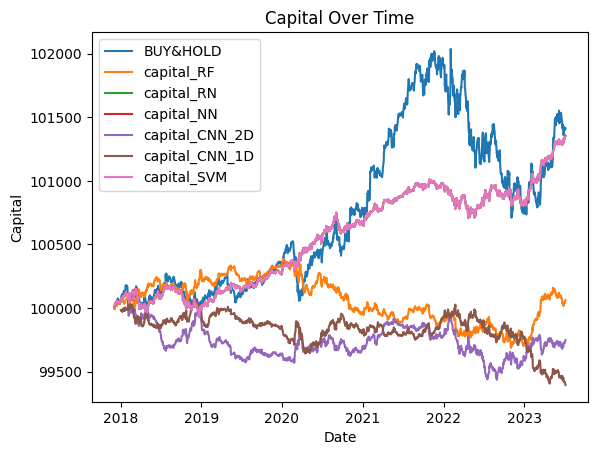

In [69]:
plt.plot(trades_total.index,trades_total['open_price']*trades_total['shares'].iloc[0]+99000, label='BUY&HOLD')
plt.plot(trades_total.index, trades_total['capital_RF'], label='capital_RF')
plt.plot(trades_total.index, trades_total['capital_RN'], label='capital_RN')
plt.plot(trades_total.index, trades_total['capital_NN'], label='capital_NN')
plt.plot(trades_total.index, trades_total['capital_CNN_2D'], label='capital_CNN_2D')
plt.plot(trades_total.index, trades_total['capital_CNN_1D'], label='capital_CNN_1D')
plt.plot(trades_total.index, trades_total['capital_SVM'], label='capital_SVM')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Capital')
plt.title('Capital Over Time')
plt.show()

We cannot see the Neural Network's plot because has the same behaivour that SVM

Recurrent Neuronal Network


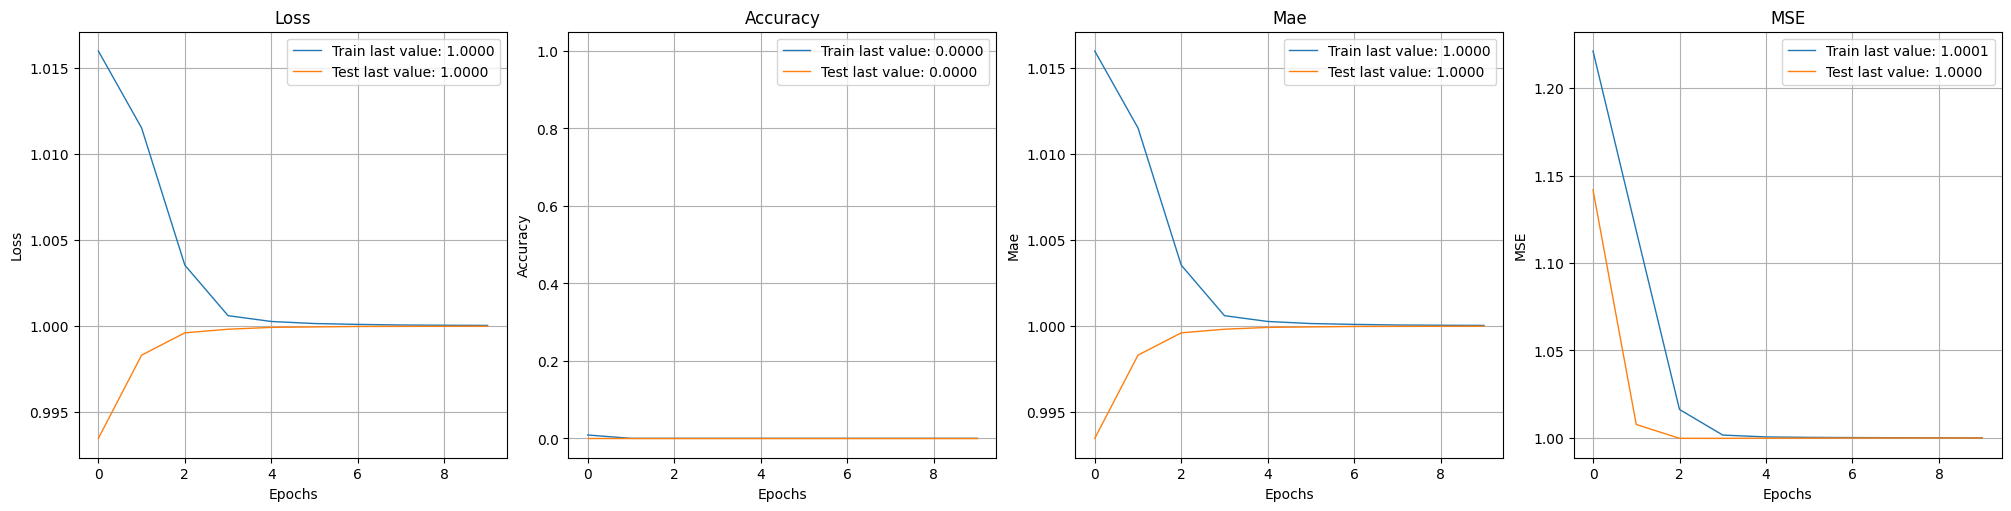

Neuronal Networks


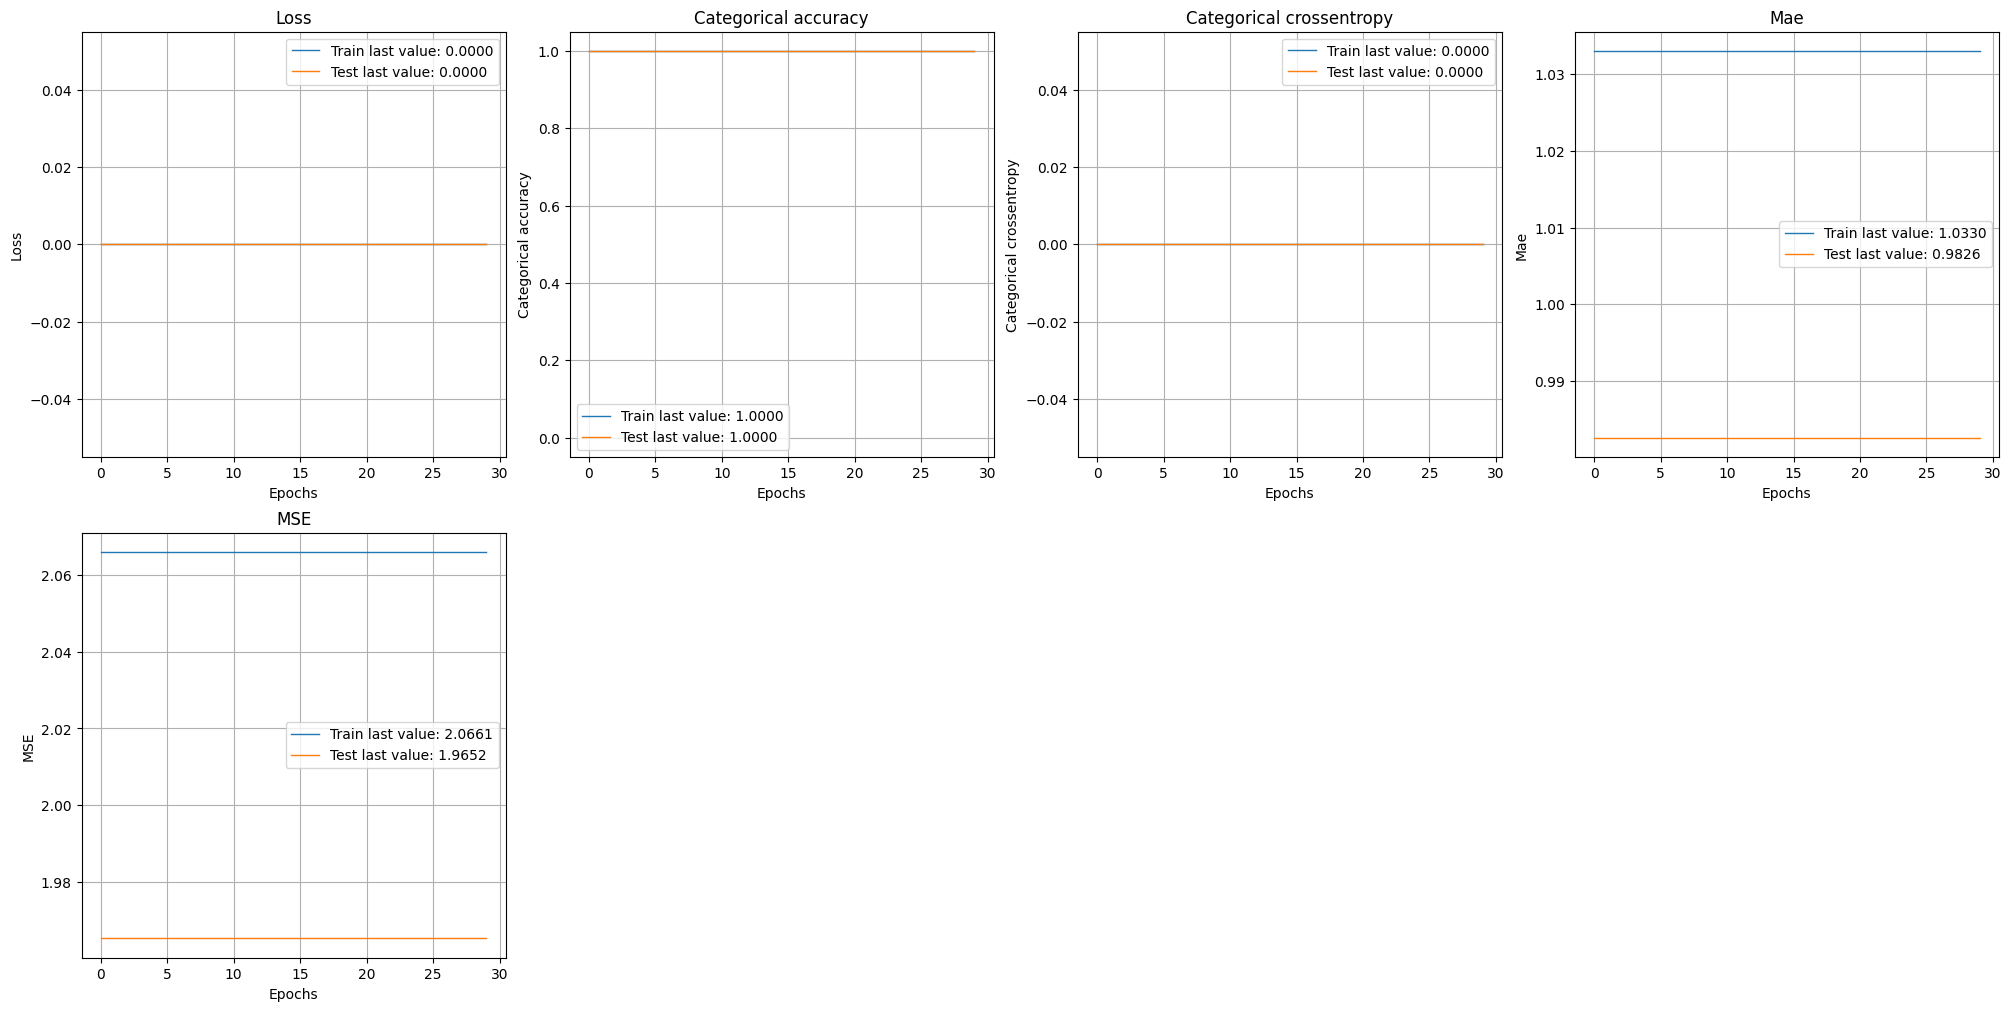

Convolutional Neuronal Network


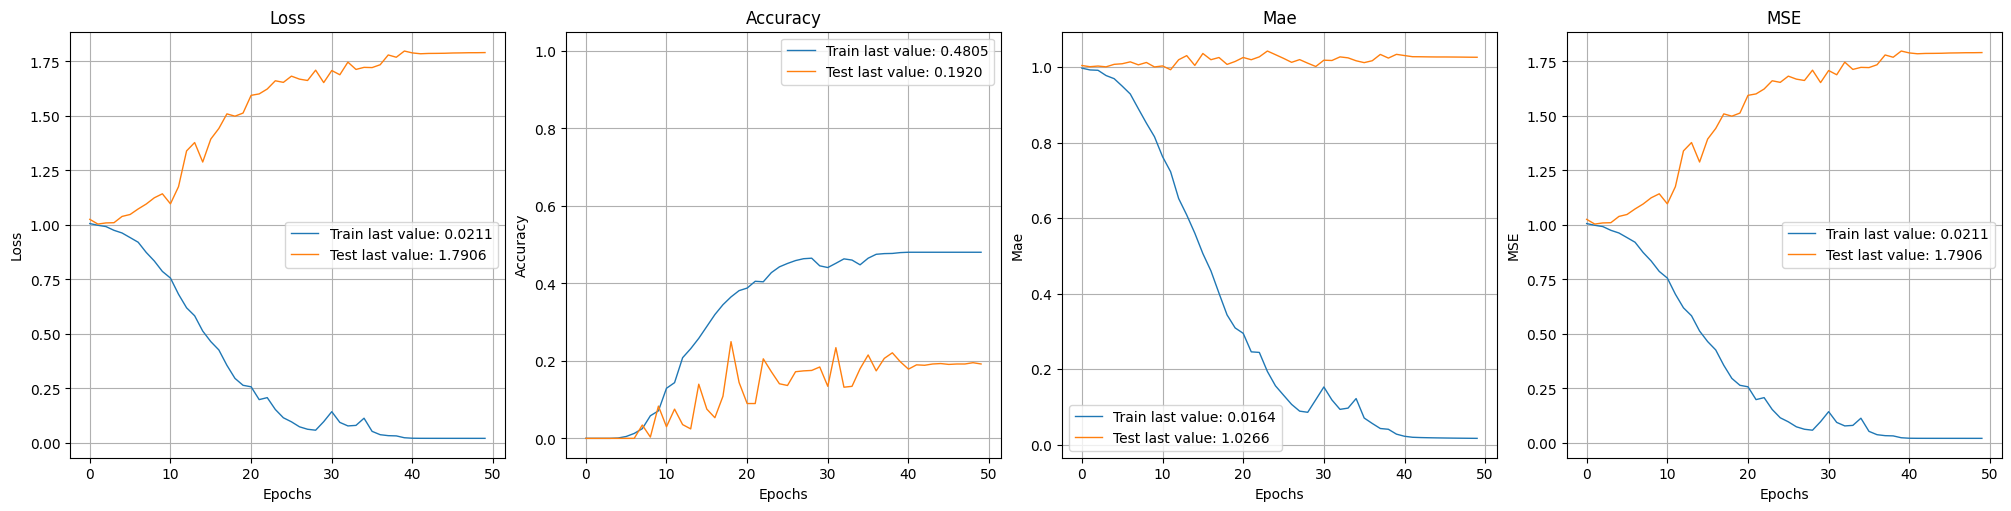

Support Vector Machine


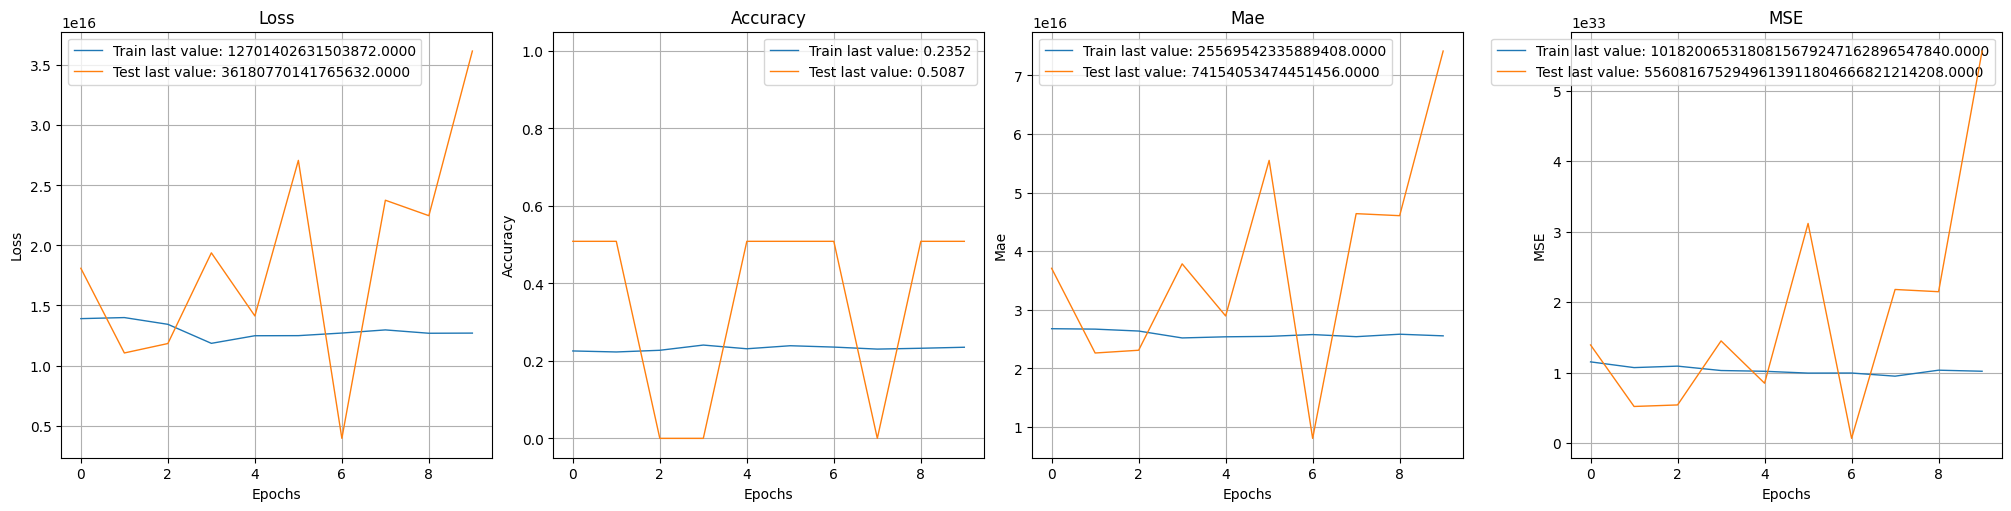

In [70]:
print("Recurrent Neuronal Network")
show_history(history_rnr)
print("Neuronal Networks")
show_history(history_nn)
print("Convolutional Neuronal Network")
show_history(history_cnn)
print("Support Vector Machine")
show_history(history_svm)


# TEST CNN 

## Predictions

In [71]:
model = RandomForestClassifier(n_estimators=78, random_state=42)
model.fit(X_train['GOOG'], y_train['GOOG'])

y_train_pred={}
y_test_pred={}
y_val_pred={}
accuracy = {}
mse = {}

for symbol in symbols:
    accuracy[symbol] ={}
    mse[symbol] ={}
    # y_train_pred[symbol] = model.predict(X_train[symbol])
    # accuracy[symbol]['train'] = accuracy_score(y_train[symbol], y_train_pred[symbol])
    # print(f"Precisión train:", accuracy[symbol]['train'])
    # mse[symbol]['train'] = mean_squared_error(y_train[symbol], y_train_pred[symbol])
    # print(f"Error cuadrático medio (MSE): {mse[symbol]['train']}\n\n")

    y_val_pred[symbol] = model.predict(X_val[symbol])
    accuracy[symbol]['val'] = accuracy_score(y_val[symbol], y_val_pred[symbol])
    print(f"Precisión val:", accuracy[symbol]['val'])
    mse[symbol]['val'] = mean_squared_error(y_val[symbol], y_val_pred[symbol])
    print(f"Error cuadrático medio (MSE): {mse[symbol]['val']}\n\n")

    y_test_pred[symbol] = model.predict(X_test[symbol])
    accuracy[symbol]['test'] = accuracy_score(y_test[symbol], y_test_pred[symbol])
    print(f"Precisión test:", accuracy[symbol]['test'])
    mse[symbol]['test'] = mean_squared_error(y_test[symbol], y_test_pred[symbol])
    print(f"Error cuadrático medio (MSE): {mse[symbol]['test']}\n\n")

Precisión val: 0.8326086956521739
Error cuadrático medio (MSE): 0.6695652173913044


Precisión test: 0.8268115942028985
Error cuadrático medio (MSE): 0.6927536231884058





Convolutional Neuronal Networks accuracy: 82.68%
Confusion matrix:
[[489 161]
 [ 78 652]]


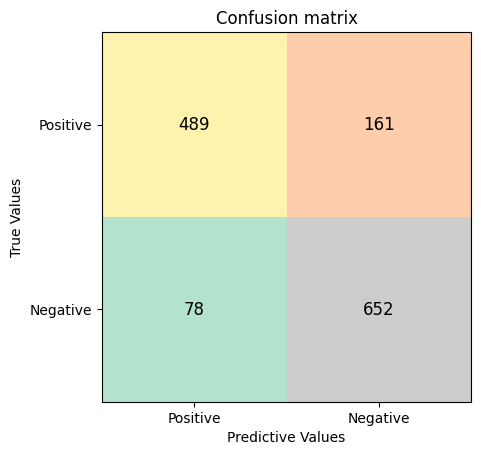

In [72]:
y_test_pred_round = np.where(y_test_pred['GOOG'] >= 0, 1, -1)

confusion_mtx = confusion_matrix(y_test['GOOG'], y_test_pred['GOOG'])

accuracy = accuracy_score(y_test['GOOG'], y_test_pred_round)
print()
print("Convolutional Neuronal Networks accuracy: {:.2f}%".format(accuracy * 100))

print("Confusion matrix:")
print(confusion_mtx)

class_labels = ['Positive', 'Negative']

plt.imshow(confusion_mtx, cmap='Pastel2')

for i in range(confusion_mtx.shape[0]):
    for j in range(confusion_mtx.shape[1]):
        plt.text(j, i, str(confusion_mtx[i, j]), ha='center', va='center', color='black', fontsize=12)

plt.title('Confusion matrix')
plt.xlabel('Predictive Values')
plt.ylabel('True Values')
plt.xticks([0, 1], class_labels)
plt.yticks([0, 1], class_labels)

plt.show()


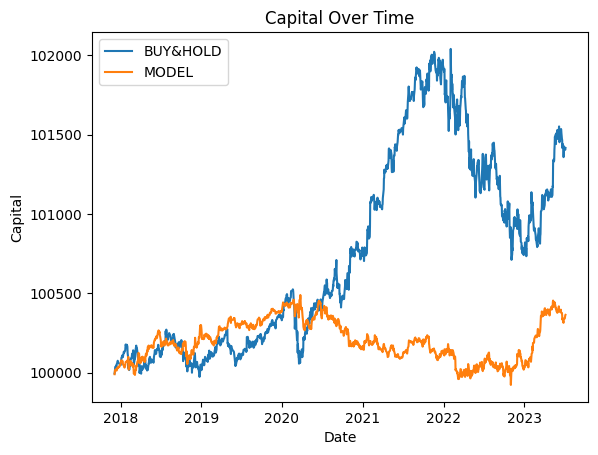

In [73]:
test_df = X_test[symbols[-1]][1:].copy()
test_df['Target'] = np.array(pd.Series(y_test_pred_round.flatten()).shift()[:-1])
test_df.dropna(inplace=True)
plotter(symbols,test_df)

In [74]:
# from sklearn.tree import plot_tree
# import matplotlib.pyplot as plt

# # Assuming "model" is your trained RandomForestClassifier
# estimator = model.estimators_[0]  # Choose a specific tree from the forest

# plt.figure(figsize=(20, 10))
# plot_tree(estimator, feature_names=X_train.columns, filled=True, rounded=True, class_names=["0", "1"])
# plt.show()

# TEST CNN NVIDIA

In [75]:
symbols = ["NVDA"]
data_dict, X_train, y_train, X_val, y_val, X_test, y_test = \
df_generator(symbols,per=per,end_date=end_date,start_date=start_date)
print('\n\nDATA NORMALIZED\n\n')
data_dict_norm, X_train_norm, y_train_norm, X_val_norm, y_val_norm, X_test_norm, y_test_norm = \
df_generator(symbols,per=per,end_date=end_date,start_date=start_date,norm=True)

[*********************100%***********************]  1 of 1 completed
Tickers:['NVDA']
We are going to work with a period of 8591 days.


DATA NORMALIZED


[*********************100%***********************]  1 of 1 completed
Tickers:['NVDA']
We are going to work with a period of 8591 days.


In [76]:
data_dict_norm, X_train_norm, y_train_norm, X_val_norm, y_val_norm, \
X_test_norm, y_test_norm = taking_target(data_dict_norm,
                                           X_train_norm,
                                           y_train_norm,
                                           X_val_norm,
                                           y_val_norm,
                                           X_test_norm,
                                           y_test_norm,
                                           target=0,
                                           symbols=symbols)
                                           
data_dict, X_train, y_train, X_val, y_val,\
X_test, y_test = taking_target(data_dict,
                                X_train,
                                y_train,
                                X_val,
                                y_val,
                                X_test,
                                y_test,
                                target=0,
                                symbols=symbols)

In [77]:
X_CNNtrain,y_CNNtrain = groups_generator_CNN(X_train_norm['NVDA'],y_train_norm['NVDA'])
X_CNNtest,y_CNNtest = groups_generator_CNN(X_test_norm['NVDA'],y_test_norm['NVDA'])
X_CNNval,y_CNNval = groups_generator_CNN(X_val_norm['NVDA'],y_val_norm['NVDA'])

(2905, 20, 59)
(1737, 20, 59)
(1150, 20, 59)


In [78]:
y_CNNpred = model_cnn.predict(X_CNNtest)

y_CNNpred_round = np.where(y_CNNpred >= 0, 1, -1)

confusion_mtx_cnn = confusion_matrix(y_CNNtest, y_CNNpred_round)

accuracy_cnn = accuracy_score(y_CNNtest, y_CNNpred_round)
print()
print("Convolutional Neuronal Networks accuracy: {:.2f}%".format(accuracy_cnn * 100))

print("Confusion matrix:")
print(confusion_mtx_cnn)

55/55 [==============================] - 0s 6ms/step

Convolutional Neuronal Networks accuracy: 79.74%
Confusion matrix:
[[   1    7]
 [ 345 1384]]


In [79]:
y_CNNtrainpred = np.where(model_cnn.predict(X_CNNtrain) >= 0, 1, -1)
y_CNNvalpred =  np.where(model_cnn.predict(X_CNNval) >= 0, 1, -1)
y_CNNtestpred = np.where(model_cnn.predict(X_CNNtest) >= 0, 1, -1)

print(f"Precisión train:", accuracy_score(y_CNNtrain, y_CNNtrainpred))
print(f"Error cuadrático medio (MSE): {mean_squared_error(y_CNNtrain, y_CNNtrainpred)}\n\n")

print(f"Precisión val:", accuracy_score(y_CNNval, y_CNNvalpred))
print(f"Error cuadrático medio (MSE): {mean_squared_error(y_CNNval, y_CNNvalpred)}\n\n")

print(f"Precisión test:", accuracy_score(y_CNNtest, y_CNNtestpred))
print(f"Error cuadrático medio (MSE): {mean_squared_error(y_CNNtest, y_CNNtestpred)}\n\n")


55/55 [==============================] - 0s 6ms/step
Precisión train: 0.5122203098106712
Error cuadrático medio (MSE): 1.951118760757315


Precisión val: 0.6660869565217391
Error cuadrático medio (MSE): 1.3356521739130436


Precisión test: 0.7973517559009787
Error cuadrático medio (MSE): 0.8105929763960852




# TEST CNN VRAY 

In [80]:
symbols = ["VRAY"]
data_dict, X_train, y_train, X_val, y_val, X_test, y_test = \
df_generator(symbols,per=per,end_date=end_date,start_date=start_date)
print('\n\nDATA NORMALIZED\n\n')
data_dict_norm, X_train_norm, y_train_norm, X_val_norm, y_val_norm, X_test_norm, y_test_norm = \
df_generator(symbols,per=per,end_date=end_date,start_date=start_date,norm=True)

[*********************100%***********************]  1 of 1 completed
Tickers:['VRAY']
We are going to work with a period of 8591 days.


DATA NORMALIZED


[*********************100%***********************]  1 of 1 completed
Tickers:['VRAY']
We are going to work with a period of 8591 days.


In [81]:
data_dict_norm, X_train_norm, y_train_norm, X_val_norm, y_val_norm, \
X_test_norm, y_test_norm = taking_target(data_dict_norm,
                                           X_train_norm,
                                           y_train_norm,
                                           X_val_norm,
                                           y_val_norm,
                                           X_test_norm,
                                           y_test_norm,
                                           target=0,
                                           symbols=symbols)
                                           
data_dict, X_train, y_train, X_val, y_val,\
X_test, y_test = taking_target(data_dict,
                                X_train,
                                y_train,
                                X_val,
                                y_val,
                                X_test,
                                y_test,
                                target=0,
                                symbols=symbols)

In [82]:
X_CNNtrain,y_CNNtrain = groups_generator_CNN(X_train_norm['VRAY'],y_train_norm['VRAY'])
X_CNNtest,y_CNNtest = groups_generator_CNN(X_test_norm['VRAY'],y_test_norm['VRAY'])
X_CNNval,y_CNNval = groups_generator_CNN(X_val_norm['VRAY'],y_val_norm['VRAY'])

(862, 20, 59)
(511, 20, 59)
(333, 20, 59)


In [83]:
y_CNNpred = model_cnn.predict(X_CNNtest)

y_CNNpred_round = np.where(y_CNNpred >= 0, 1, -1)

confusion_mtx_cnn = confusion_matrix(y_CNNtest, y_CNNpred_round)

accuracy_cnn = accuracy_score(y_CNNtest, y_CNNpred_round)
print()
print("Convolutional Neuronal Networks accuracy: {:.2f}%".format(accuracy_cnn * 100))

print("Confusion matrix:")
print(confusion_mtx_cnn)

16/16 [==============================] - 0s 6ms/step

Convolutional Neuronal Networks accuracy: 55.19%
Confusion matrix:
[[178 104]
 [125 104]]


In [84]:
y_CNNtrainpred = np.where(model_cnn.predict(X_CNNtrain) >= 0, 1, -1)
y_CNNvalpred =  np.where(model_cnn.predict(X_CNNval) >= 0, 1, -1)
y_CNNtestpred = np.where(model_cnn.predict(X_CNNtest) >= 0, 1, -1)

print(f"Precisión train:", accuracy_score(y_CNNtrain, y_CNNtrainpred))
print(f"Error cuadrático medio (MSE): {mean_squared_error(y_CNNtrain, y_CNNtrainpred)}\n\n")

print(f"Precisión val:", accuracy_score(y_CNNval, y_CNNvalpred))
print(f"Error cuadrático medio (MSE): {mean_squared_error(y_CNNval, y_CNNvalpred)}\n\n")

print(f"Precisión test:", accuracy_score(y_CNNtest, y_CNNtestpred))
print(f"Error cuadrático medio (MSE): {mean_squared_error(y_CNNtest, y_CNNtestpred)}\n\n")

16/16 [==============================] - 0s 6ms/step
Precisión train: 0.5162412993039444
Error cuadrático medio (MSE): 1.9350348027842228


Precisión val: 0.4984984984984985
Error cuadrático medio (MSE): 2.006006006006006


Precisión test: 0.5518590998043053
Error cuadrático medio (MSE): 1.7925636007827788




# TEST BITCOIN-USD

In [85]:
symbols = ["BTC-USD"]
data_dict, X_train, y_train, X_val, y_val, X_test, y_test = \
df_generator(symbols,per=per,end_date=end_date,start_date=start_date)
print('\n\nDATA NORMALIZED\n\n')
data_dict_norm, X_train_norm, y_train_norm, X_val_norm, y_val_norm, X_test_norm, y_test_norm = \
df_generator(symbols,per=per,end_date=end_date,start_date=start_date,norm=True)

[*********************100%***********************]  1 of 1 completed
Tickers:['BTC-USD']
We are going to work with a period of 8591 days.


DATA NORMALIZED


[*********************100%***********************]  1 of 1 completed
Tickers:['BTC-USD']
We are going to work with a period of 8591 days.


In [86]:
data_dict['BTC-USD'].Target.value_counts()

 1    1669
-1    1476
 0      39
Name: Target, dtype: int64

In [87]:
data_dict_norm, X_train_norm, y_train_norm, X_val_norm, y_val_norm, \
X_test_norm, y_test_norm = taking_target(data_dict_norm,
                                           X_train_norm,
                                           y_train_norm,
                                           X_val_norm,
                                           y_val_norm,
                                           X_test_norm,
                                           y_test_norm,
                                           target=0,
                                           symbols=symbols)
                                           
data_dict, X_train, y_train, X_val, y_val,\
X_test, y_test = taking_target(data_dict,
                                X_train,
                                y_train,
                                X_val,
                                y_val,
                                X_test,
                                y_test,
                                target=0,
                                symbols=symbols)

In [88]:
X_CNNtrain,y_CNNtrain = groups_generator_CNN(X_train_norm['BTC-USD'],y_train_norm['BTC-USD'])
X_CNNtest,y_CNNtest = groups_generator_CNN(X_test_norm['BTC-USD'],y_test_norm['BTC-USD'])
X_CNNval,y_CNNval = groups_generator_CNN(X_val_norm['BTC-USD'],y_val_norm['BTC-USD'])

(1553, 20, 59)
(925, 20, 59)
(610, 20, 59)


In [89]:
y_CNNpred = model_cnn.predict(X_CNNtest)

y_CNNpred_round = np.where(y_CNNpred >= 0, 1, -1)

confusion_mtx_cnn = confusion_matrix(y_CNNtest, y_CNNpred_round)

accuracy_cnn = accuracy_score(y_CNNtest, y_CNNpred_round)
print()
print("Convolutional Neuronal Networks accuracy: {:.2f}%".format(accuracy_cnn * 100))

print("Confusion matrix:")
print(confusion_mtx_cnn)

29/29 [==============================] - 0s 6ms/step

Convolutional Neuronal Networks accuracy: 50.27%
Confusion matrix:
[[268 202]
 [258 197]]


In [90]:
y_CNNtrainpred = np.where(model_cnn.predict(X_CNNtrain) >= 0, 1, -1)
y_CNNvalpred =  np.where(model_cnn.predict(X_CNNval) >= 0, 1, -1)
y_CNNtestpred = np.where(model_cnn.predict(X_CNNtest) >= 0, 1, -1)

print(f"Precisión train:", accuracy_score(y_CNNtrain, y_CNNtrainpred))
print(f"Error cuadrático medio (MSE): {mean_squared_error(y_CNNtrain, y_CNNtrainpred)}\n\n")

print(f"Precisión val:", accuracy_score(y_CNNval, y_CNNvalpred))
print(f"Error cuadrático medio (MSE): {mean_squared_error(y_CNNval, y_CNNvalpred)}\n\n")

print(f"Precisión test:", accuracy_score(y_CNNtest, y_CNNtestpred))
print(f"Error cuadrático medio (MSE): {mean_squared_error(y_CNNtest, y_CNNtestpred)}\n\n")

29/29 [==============================] - 0s 8ms/step
Precisión train: 0.5254346426271732
Error cuadrático medio (MSE): 1.8982614294913072


Precisión val: 0.4918032786885246
Error cuadrático medio (MSE): 2.0327868852459017


Precisión test: 0.5027027027027027
Error cuadrático medio (MSE): 1.9891891891891893




# TEST S&P ^GSPC

In [91]:
symbols = ["^GSPC"]
data_dict, X_train, y_train, X_val, y_val, X_test, y_test = \
df_generator(symbols,per=per,end_date=end_date,start_date=start_date)
print('\n\nDATA NORMALIZED\n\n')
data_dict_norm, X_train_norm, y_train_norm, X_val_norm, y_val_norm, X_test_norm, y_test_norm = \
df_generator(symbols,per=per,end_date=end_date,start_date=start_date,norm=True)

[*********************100%***********************]  1 of 1 completed
Tickers:['^GSPC']
We are going to work with a period of 8591 days.


DATA NORMALIZED


[*********************100%***********************]  1 of 1 completed
Tickers:['^GSPC']
We are going to work with a period of 8591 days.


In [92]:
data_dict['^GSPC'].Target.value_counts()

 1    3026
-1    2644
 0     211
Name: Target, dtype: int64

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=dda2d425-17f7-4b78-8eda-6ab769d91924' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>